## Librerías

In [285]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from scipy.stats import mode
from ydata_profiling import ProfileReport

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from catboost import CatBoostRegressor, Pool

## Importar Dataset

In [286]:
# Importar archivo excel desde el Drive

ruta_archivo = Path(r"/Users/valetedesco/Library/CloudStorage/GoogleDrive-grupotesisummcd@gmail.com/.shortcut-targets-by-id/1aI4ids63D_lROjgqkvdwMPmzc-h0_Cc_/Tesis | MCD | UM/turismo_receptivo.xlsx")
#ruta_archivo = Path(r"H:\.shortcut-targets-by-id\1aI4ids63D_lROjgqkvdwMPmzc-h0_Cc_\Tesis   MCD   UM\turismo_receptivo.xlsx")

df = pd.read_excel(ruta_archivo)

df.head()

IdIngresos Lugar Ingreso  IdTranspIngreso  \
0           1       Colonia                5   
1           8      Paysandú                2   
2           8      Paysandú                2   
3          16   Bella Unión                2   
4           8      Paysandú                2   

  Transporte Internacional de Ingreso FechaIngreso  IdFecIng FechaEgreso  \
0                  Maritimo - Fluvial   2017-01-02     13516  2017-01-02   
1                      Terrestre Auto   2017-01-02     13516  2017-01-02   
2                      Terrestre Auto   2017-01-02     13516  2017-01-02   
3                      Terrestre Auto   2017-01-02     13516  2017-01-02   
4                      Terrestre Auto   2017-01-02     13516  2017-01-02   

   IdFecEgr  IdNacionalidad       Pais  ...  GastoTotal GastoAlojamiento  \
0     13516              10  Argentina  ...      1537.5              0.0   
1     13516              10  Argentina  ...        70.0             60.0   
2     13516              10  Argentina  ...        70.0             60.0   
3     13516              19     Brasil  ...       161.0              0.0   
4     13516              10  Argentina  ...        50.0              0.0   

   GastoAlimentacion GastoTransporte  GastoCultural GastoTours  GastoCompras  \
0               55.5             0.0          411.0        0.0        1038.0   
1                0.0            10.0            0.0        0.0           0.0   
2                0.0            10.0            0.0        0.0           0.0   
3               26.0             5.0            0.0        0.0         130.0   
4               40.0            10.0            0.0        0.0           0.0   

  GastoOtros    Coef CoefTot  
0       33.0  153.46  460.39  
1        0.0  128.53  514.13  
2        0.0  128.53  514.13  
3        0.0   57.49  114.98  
4        0.0  128.53  514.13  

[5 rows x 48 columns]

In [287]:
# Ver resumen de df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65333 entries, 0 to 65332
Data columns (total 48 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   IdIngresos                           65333 non-null  int64         
 1   Lugar Ingreso                        65333 non-null  object        
 2   IdTranspIngreso                      65333 non-null  int64         
 3   Transporte Internacional de Ingreso  65333 non-null  object        
 4   FechaIngreso                         65333 non-null  datetime64[ns]
 5   IdFecIng                             65333 non-null  int64         
 6   FechaEgreso                          65333 non-null  datetime64[ns]
 7   IdFecEgr                             65333 non-null  int64         
 8   IdNacionalidad                       65333 non-null  int64         
 9   Pais                                 65333 non-null  object        
 10  IdResidenc

In [288]:
# Cantidad de variables por tipo de dato

df.dtypes.value_counts()

int64             16
object            16
float64           14
datetime64[ns]     2
Name: count, dtype: int64

## Análisis Exploratorio de Datos

In [289]:
# Eliminar columnas de 'Id'

cols_to_drop = [col for col in df.columns if col.startswith('Id')] + ['IsEstudio']
df = df.drop(columns=cols_to_drop)

In [290]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65333 entries, 0 to 65332
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Lugar Ingreso                        65333 non-null  object        
 1   Transporte Internacional de Ingreso  65333 non-null  object        
 2   FechaIngreso                         65333 non-null  datetime64[ns]
 3   FechaEgreso                          65333 non-null  datetime64[ns]
 4   Pais                                 65333 non-null  object        
 5   Residencia                           65333 non-null  object        
 6   Motivo                               65333 non-null  object        
 7   Ocupacion                            65333 non-null  object        
 8   Estudio                              44882 non-null  object        
 9   Localidad                            65317 non-null  object        
 10  Departamen

In [291]:
# Verificar composición de variable 'Estadia''

print(df['Estadia'].unique())

[  0.5   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
  12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
  24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.
  36.   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.
  48.   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.
  60.   61.   62.   63.   64.   65.   66.   68.   70.   71.   72.   73.
  74.   75.   76.   79.   80.   81.   82.   83.   84.   85.   87.   88.
  90.   94.   95.   97.   99.  100.  101.  102.  104.  108.  112.  113.
 114.  118.  120.  123.  125.  133.  137.  138.  143.  145.  147.  156.
 160.  163.  167.  171.  183.  187.  210.  217.  219.  245.  276.  365. ]


In [292]:
# Cantidad de valores de la variable estadia

df['Estadia'].value_counts().sort_index()

Estadia
0.5      3615
1.0      5219
2.0      7246
3.0      8941
4.0      7844
         ... 
217.0       1
219.0       1
245.0       1
276.0       2
365.0       1
Name: count, Length: 120, dtype: int64

In [293]:
# Redondear los valores de 'Estadia' y convertir a entero, asegurando que el mínimo sea 1

df['Estadia'] = np.floor(df['Estadia'] + 0.5).astype(int)

print(df['Estadia'].sort_values().unique())

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  68  70  71  72  73  74
  75  76  79  80  81  82  83  84  85  87  88  90  94  95  97  99 100 101
 102 104 108 112 113 114 118 120 123 125 133 137 138 143 145 147 156 160
 163 167 171 183 187 210 217 219 245 276 365]


In [294]:
# Valores de 'Estadia' menores a 50 días

count_menor_50 = df[df['Estadia'] <= 50].shape[0]
print(f"Número de registros con 'Estadia' menor a 50 días: {count_menor_50}") 

Número de registros con 'Estadia' menor a 50 días: 65175


In [295]:
# Valores de 'Estadia' mayor a 50 días

count_mayor_50 = df[df['Estadia'] > 50].shape[0]
print(f"Número de registros con 'Estadia' mayor a 50 días: {count_mayor_50}")  

Número de registros con 'Estadia' mayor a 50 días: 158


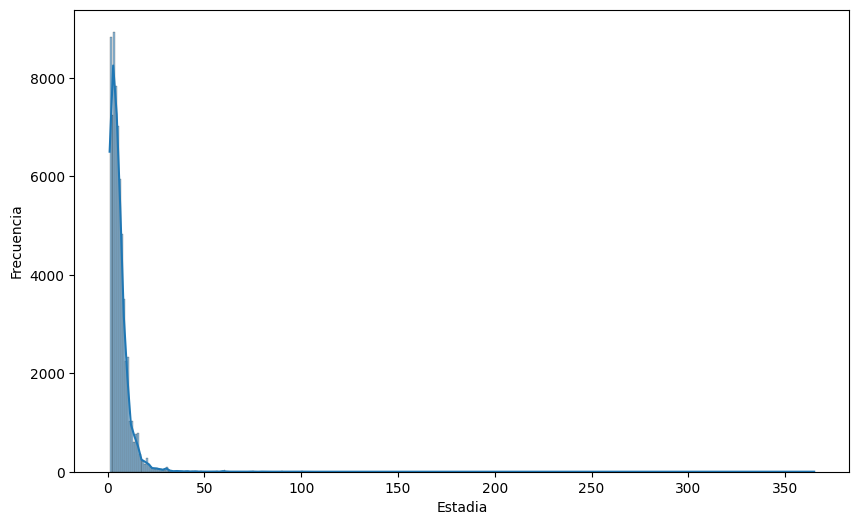

In [296]:
# Distribución de la variable 'Estadia'

plt.figure(figsize=(10, 6))
sns.histplot(df['Estadia'], bins=365, kde=True)
plt.xlabel('Estadia')
plt.ylabel('Frecuencia')
plt.show()

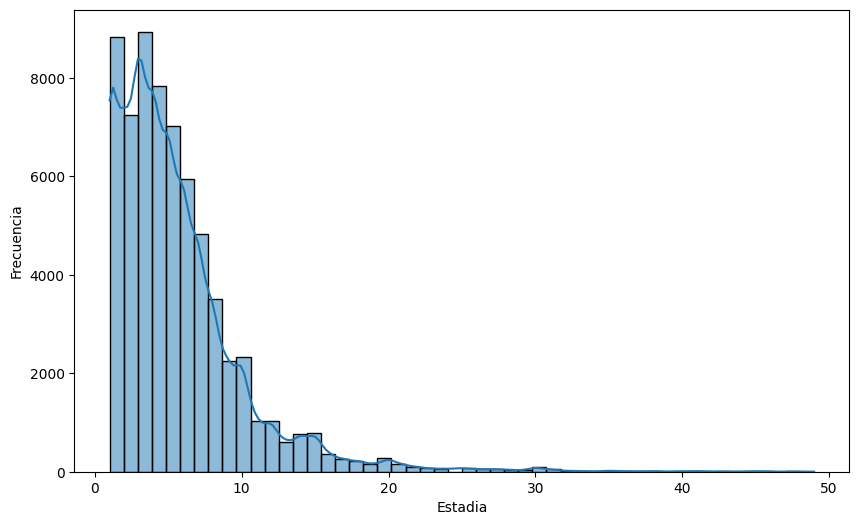

In [297]:
# Distribución de la variable 'Estadia' menor a 50 dias

plt.figure(figsize=(10, 6))
sns.histplot(df[df['Estadia'] < 50]['Estadia'], bins=50, kde=True)
plt.xlabel('Estadia')
plt.ylabel('Frecuencia')
plt.show()

In [298]:
# Porcentaje de la distribucion de 'Estadia' menor a 50 dias

porcentaje_menor_50 = (df[df['Estadia'] < 50].shape[0] / df.shape[0]) * 100
print(f"Porcentaje de registros con 'Estadia' menor a 50 días: {porcentaje_menor_50:.2f}%") 

Porcentaje de registros con 'Estadia' menor a 50 días: 99.75%


In [299]:
# Verificar composición de varibale 'Gente'

print(df['Gente'].unique())

[ 3  4  2  5  1  6  7  8  9 10 14 15 11 20 30 12 16 13]


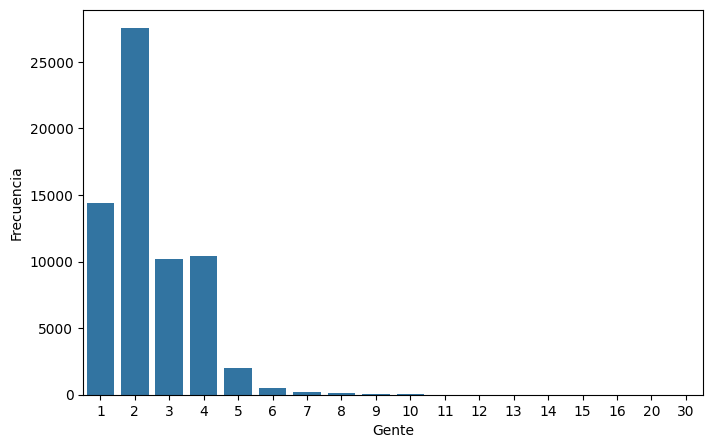

In [300]:
# Distribución de la variable 'Gente'

plt.figure(figsize=(8, 5))
orden_gente = sorted(df['Gente'].unique())
sns.countplot(data=df, x='Gente', order=orden_gente)
plt.xlabel('Gente')
plt.ylabel('Frecuencia')
plt.show()

In [301]:
# Estadísticos descriptivos de la variable 'Gasto Total'

df['GastoTotal'].describe()

count    65333.000000
mean      1368.821987
std       1886.165841
min          0.000000
25%        287.130000
50%        734.440000
75%       1700.000000
max      49036.640000
Name: GastoTotal, dtype: float64

In [302]:
# Verificar si hay valores nulos en 'GastoTotal'

nulos = df['GastoTotal'].isnull().sum()
print(f"Número de valores nulos en 'GastoTotal': {nulos}")

Número de valores nulos en 'GastoTotal': 0


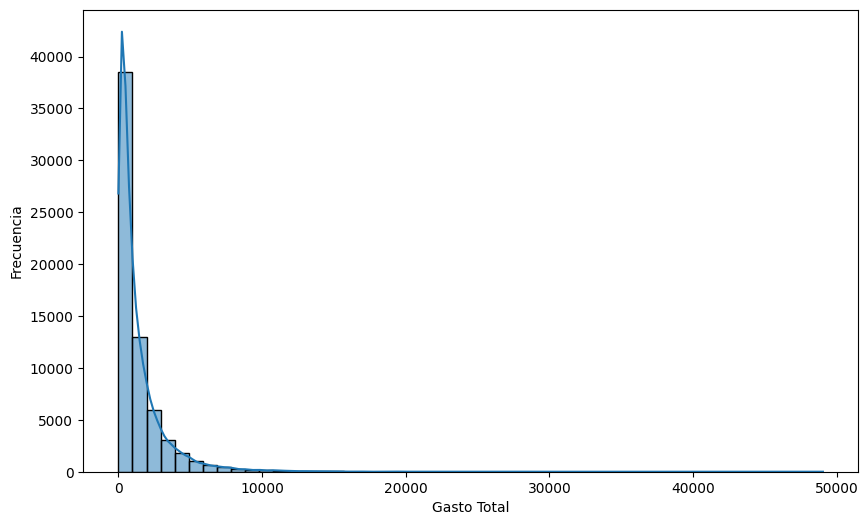

In [303]:
# Distribución de la variable 'Gasto Total'

plt.figure(figsize=(10, 6))
sns.histplot(df['GastoTotal'].dropna(), bins=50, kde=True)
plt.xlabel('Gasto Total')
plt.ylabel('Frecuencia')
plt.show()

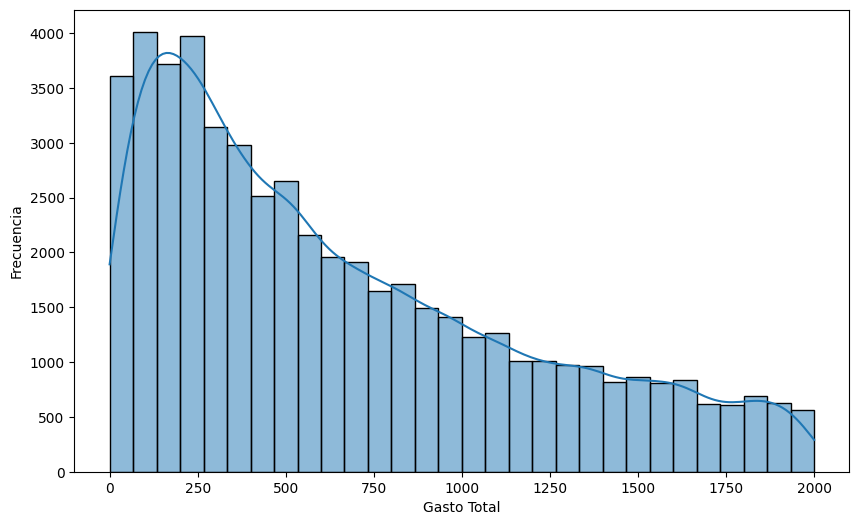

In [304]:
# Distribución de 'Gasto Total' menor a 2000

plt.figure(figsize=(10, 6))
sns.histplot(df[df['GastoTotal'] < 2000]['GastoTotal'].dropna(), bins=30, kde=True)
plt.xlabel('Gasto Total')
plt.ylabel('Frecuencia')
plt.show()

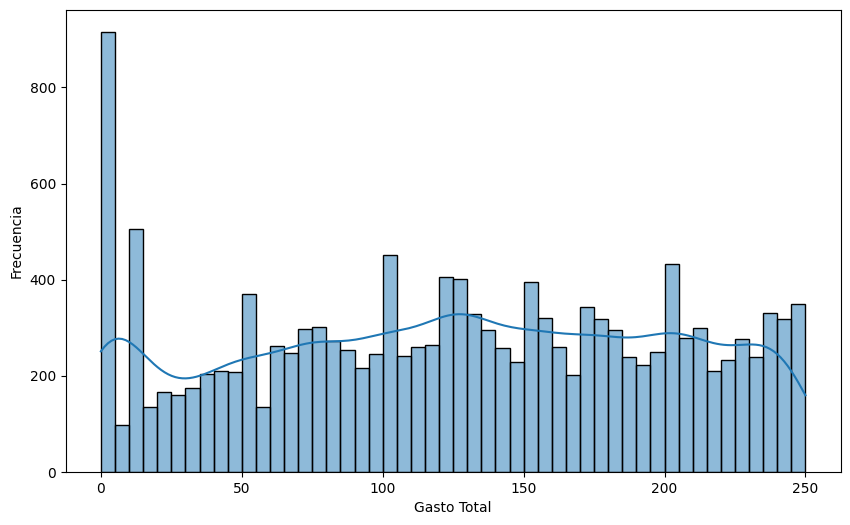

In [305]:
# Distribución de 'Gasto Total' acotada entre 0 y 250

plt.figure(figsize=(10, 6))
sns.histplot(df[df['GastoTotal'] <= 250]['GastoTotal'].dropna(), bins=50, kde=True)
plt.xlabel('Gasto Total')
plt.ylabel('Frecuencia')
plt.show()

In [306]:
# Cantidad de valores con 'GastoTotal' igual a 0

df[df['GastoTotal'] == 0].shape[0]

882

In [307]:
# Cantidad de valores con 'GastoTotal' menor o igual a 5

df[df['GastoTotal'] <= 5].shape[0]

917

In [308]:
# Eliminar registros con GastoTotal menor o igual a 5

df = df[df['GastoTotal'] > 5].copy()

In [309]:
# Verificar que se eliminaron correctamente los registros con GastoTotal <= 5

df[df['GastoTotal'] <= 5]

Empty DataFrame
Columns: [Lugar Ingreso, Transporte Internacional de Ingreso, FechaIngreso, FechaEgreso, Pais, Residencia, Motivo, Ocupacion, Estudio, Localidad, Departamento, Otro Departamento, Otra Localidad, Alojamiento, TransporteLocal, Lugar Egreso, Transporte Internacional de Egreso, Destino, Estadia, Gente, GastoTotal, GastoAlojamiento, GastoAlimentacion, GastoTransporte, GastoCultural, GastoTours, GastoCompras, GastoOtros, Coef, CoefTot]
Index: []

[0 rows x 30 columns]

<Axes: xlabel='Estadia', ylabel='GastoTotal'>

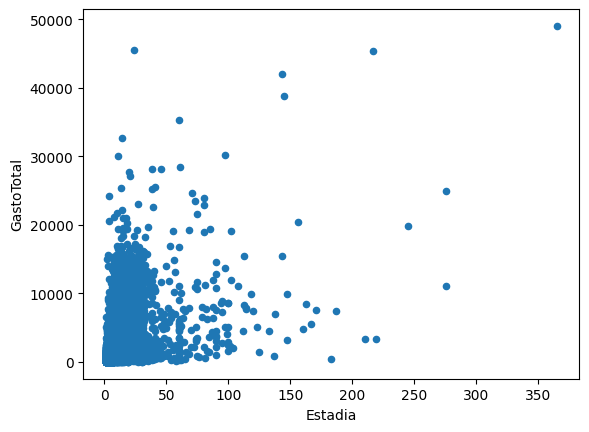

In [310]:
# Relación entre 'Estadia' y 'GastoTotal'

df.plot.scatter('Estadia', 'GastoTotal')

<Axes: xlabel='Gente', ylabel='GastoTotal'>

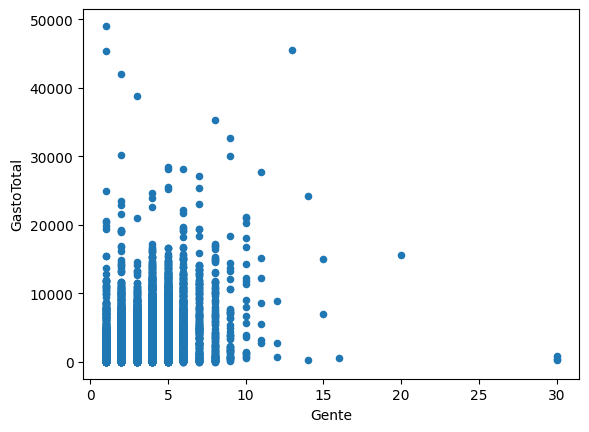

In [311]:
# Relación entre 'Gente'y 'GastoTotal'

df.plot.scatter('Gente', 'GastoTotal')

In [312]:
# Crear columna de Gasto total por día y por persona

df['Gasto/p/d'] = (df['GastoTotal'] / df['Gente'] / df['Estadia']).astype('float64')

In [313]:
# Estadísticos descriptivos de 'Gasto/p/d'

df['Gasto/p/d'].describe()

count    64416.000000
mean       100.513680
std         77.698711
min          0.380625
25%         48.981429
50%         87.995000
75%        137.145729
max       6526.760000
Name: Gasto/p/d, dtype: float64

In [314]:
# Cuantiles seleccionados de 'Gasto/p/d'

quantiles = df['Gasto/p/d'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print("Cuantiles seleccionados:\n", quantiles)

Cuantiles seleccionados:
 0.01      5.661244
0.05     17.029375
0.25     48.981429
0.50     87.995000
0.75    137.145729
0.95    224.019722
0.99    321.997450
Name: Gasto/p/d, dtype: float64


In [315]:
# Eliminar outliers en 'Gasto/p/d'

q_high = df["Gasto/p/d"].quantile(0.99)
df = df[df["Gasto/p/d"] < q_high].copy()

In [316]:
# Estadísticos descriptivos de 'Gasto/p/d' luego de eliminar outliers

col = 'Gasto/p/d'
print(df[col].describe())

count    63771.000000
mean        97.072837
std         61.523422
min          0.380625
25%         48.589042
50%         87.272750
75%        135.542750
max        321.983000
Name: Gasto/p/d, dtype: float64


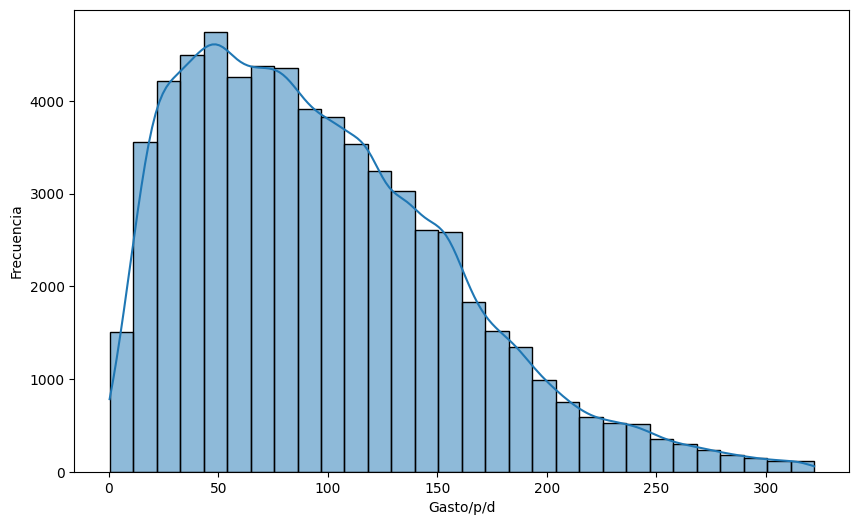

In [317]:
# Distribucion del 'Gasto/p/d' luego de eliminar outliers

plt.figure(figsize=(10, 6))
sns.histplot(df['Gasto/p/d'], bins=30, kde=True)
plt.xlabel('Gasto/p/d')
plt.ylabel('Frecuencia')
plt.show()

In [318]:
# Eliminar columnas de Gasto que no se usarán en el modelo

cols_a_eliminar = [
    'GastoTotal', 'GastoAlimentacion','GastoTransporte',
    'GastoCultural','GastoTours','GastoCompras','GastoOtros','Coef','CoefTot'
]
df = df.drop(columns=[col for col in cols_a_eliminar if col in df.columns])

In [319]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63771 entries, 1 to 65332
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Lugar Ingreso                        63771 non-null  object        
 1   Transporte Internacional de Ingreso  63771 non-null  object        
 2   FechaIngreso                         63771 non-null  datetime64[ns]
 3   FechaEgreso                          63771 non-null  datetime64[ns]
 4   Pais                                 63771 non-null  object        
 5   Residencia                           63771 non-null  object        
 6   Motivo                               63771 non-null  object        
 7   Ocupacion                            63771 non-null  object        
 8   Estudio                              43906 non-null  object        
 9   Localidad                            63758 non-null  object        
 10  Departamento   

In [ ]:
# Generar informe EDA automático

profile = ProfileReport(df, title="Informe EDA Automático", explorative=True)
profile.to_notebook_iframe()
profile.to_file("informe_eda_automatico.html")

In [321]:
# Variables categóricas y su relación con 'Gasto/p/d'

variables = ["Motivo", "Pais", "Destino", "Alojamiento", "Ocupacion"]

tabla_final = []

for var in variables:

    temp = (
        df.groupby(var)["Gasto/p/d"]
        .mean()
        .sort_values(ascending=False)
        .head(5)
        .reset_index()
    )
    
    temp.columns = ["Categoria", "Promedio Gasto/p/d"]
    temp["Variable"] = var
    temp = temp[["Variable", "Categoria", "Promedio Gasto/p/d"]]
    
    tabla_final.append(temp)

tabla_compilada = pd.concat(tabla_final, ignore_index=True)
tabla_compilada

Variable                        Categoria  Promedio Gasto/p/d
0        Motivo                             MICE          135.090076
1        Motivo                          Compras          134.222586
2        Motivo            Trabajo / Profesional          125.710832
3        Motivo               Segunda Residencia          110.217210
4        Motivo                Ocio y vacaciones          109.994358
5          Pais                           Mexico          129.470172
6          Pais                  Otro de America          128.622074
7          Pais                         Paraguay          128.505985
8          Pais                            Chile          119.695754
9          Pais                           Canada          118.504067
10      Destino                   Punta del Este          149.532699
11      Destino                       Montevideo          108.671017
12      Destino                       Piriapolis           95.798526
13      Destino                          Colonia           85.835920
14      Destino                 Costas Oceanicas           69.976593
15  Alojamiento                Hotel 5 estrellas          175.333451
16  Alojamiento                Hotel 4 estrellas          159.391143
17  Alojamiento                Hotel 3 estrellas          133.914268
18  Alojamiento            Hotel sin categorizar          131.464175
19  Alojamiento                  Vivienda propia          125.202147
20    Ocupacion                Director, gerente          130.788133
21    Ocupacion     Patron, Com, Ind, Prod Agrop          118.509444
22    Ocupacion  Prof, Tecnico, Docente, Artista          116.927920
23    Ocupacion        Profesional independiente          110.753465
24    Ocupacion          Profesional dependiente          106.576203

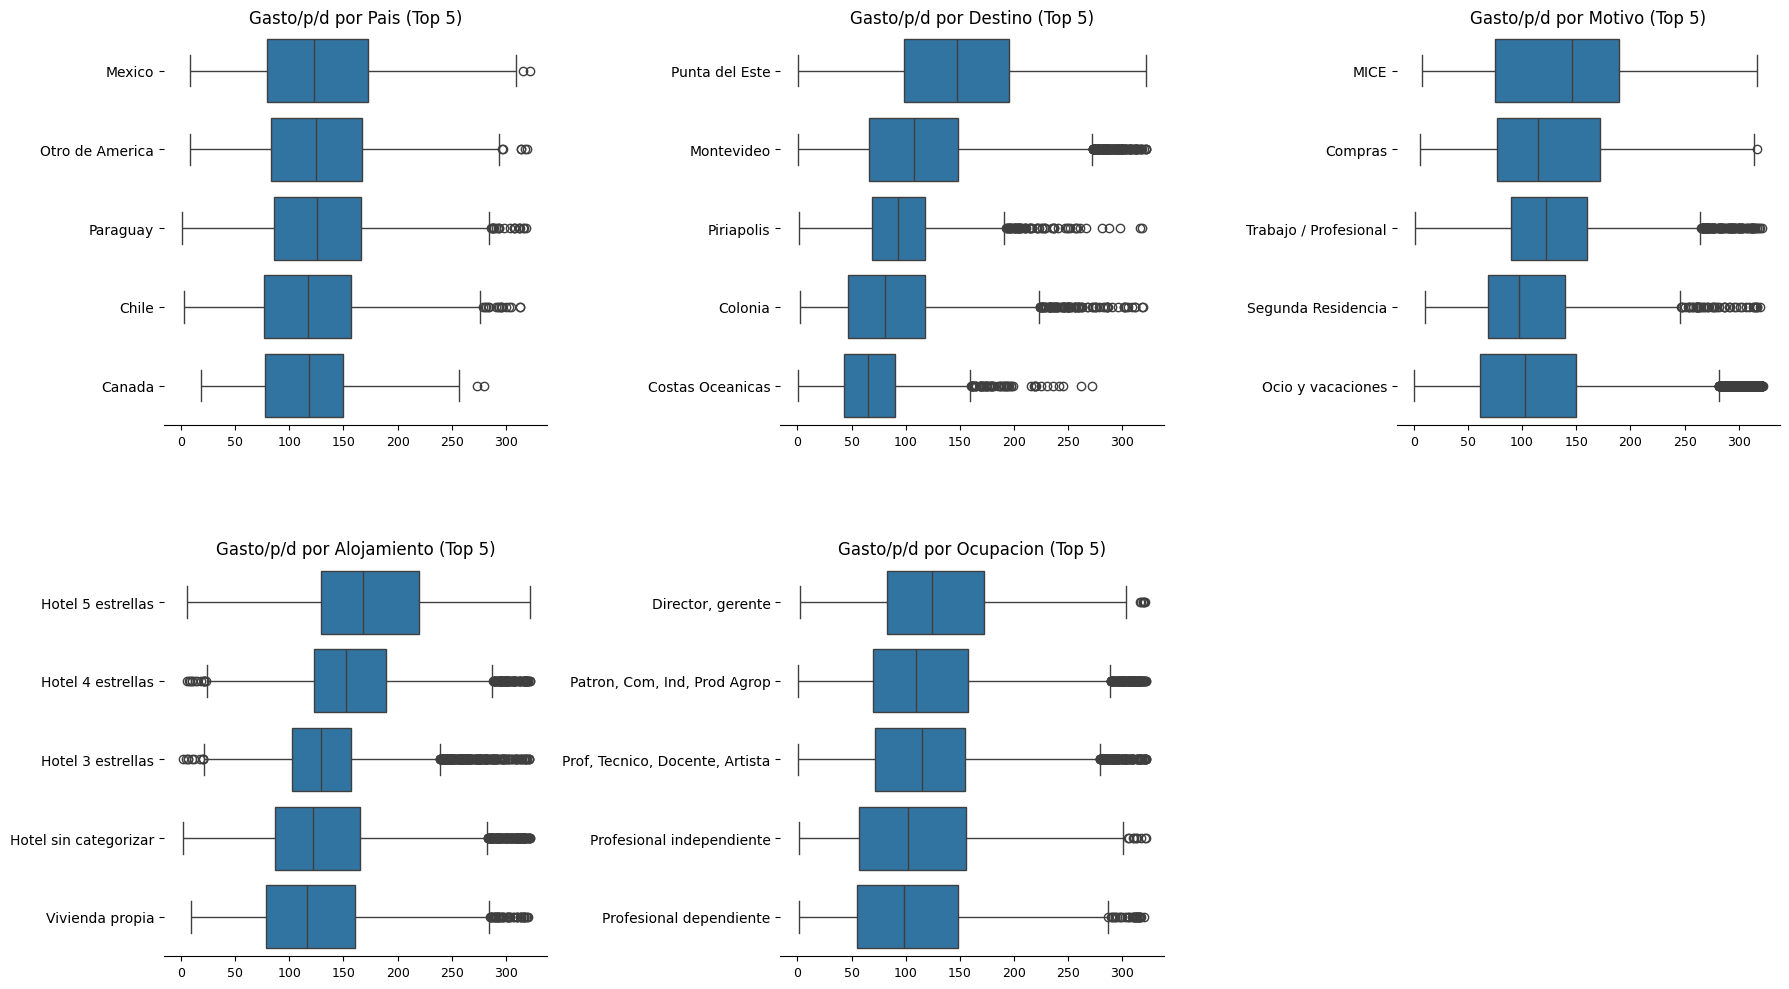

In [322]:
# Visualizar boxplots de 'Gasto/p/d' para las principales categorías de cada variable categórica

variables = ["Pais", "Destino", "Motivo", "Alojamiento", "Ocupacion"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for ax, var in zip(axes, variables):

    top5_categorias = (
        df.groupby(var)["Gasto/p/d"]
        .mean()
        .sort_values(ascending=False)
        .head(5)
        .index
    )
    
    temp = df[df[var].isin(top5_categorias)].copy()
    
    orden_categorias = (
        temp.groupby(var)["Gasto/p/d"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    sns.boxplot(
        data=temp,
        x="Gasto/p/d",
        y=var,
        order=orden_categorias,
        orient="h",
        ax=ax,
        showfliers=True
    )

    ax.set_title(f"Gasto/p/d por {var} (Top 5)", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelbottom=True, labelsize=9)
    ax.grid(False)
    sns.despine(ax=ax, top=True, right=True, left=True)

axes[-1].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(hspace=0.35)
plt.show()

## Transformaciones

### Transformaciones df original

In [323]:
# Crear columna con el mes de ingreso y egreso

df['Mes_Ingreso'] = df['FechaIngreso'].dt.month

df['Mes_Egreso'] = df['FechaEgreso'].dt.month

In [324]:
# Crear nuevas columnas con el formato 'Quarter/Year' para Ingreso y Egreso

df['Quarter_Year_Ingreso'] = df['FechaIngreso'].dt.to_period('Q').astype(str).apply(lambda x: int(x.replace('Q','')))
df['Quarter_Year_Egreso'] = df['FechaEgreso'].dt.to_period('Q').astype(str).apply(lambda x: int(x.replace('Q','')))

In [325]:
# Definir etiquetas de Temporada según mes de ingreso

condiciones = [
    df['Mes_Ingreso'].isin([1, 2, 3, 12]),   # Alta
    df['Mes_Ingreso'].isin([4, 5, 10, 11]),  # Media
    df['Mes_Ingreso'].isin([6, 7, 8, 9])     # Baja
]

valores = ['Alta', 'Media', 'Baja']

df['Temporada'] = np.select(condiciones, valores, default='Desconocido')

df[['Mes_Ingreso', 'Temporada']].drop_duplicates().sort_values('Mes_Ingreso')


Mes_Ingreso Temporada
1              1      Alta
181            2      Alta
385            3      Alta
491            4     Media
532            5     Media
568            6      Baja
609            7      Baja
656            8      Baja
710            9      Baja
756           10     Media
806           11     Media
851           12      Alta

In [326]:
# Crear columna binaria "Gasta en Alojamiento?"

df['Gasta en Alojamiento?'] = np.where(df['GastoAlojamiento'].fillna(0) > 0, 'Si', 'No')

In [327]:
# Crear columna transito

df['Es Transito?'] = np.where(
    (
        ((df['Motivo'] == 'Transito') & (df['Gasta en Alojamiento?'] == 'No')) |
        ((df['Motivo'] == 'Transito') & (df['Gasta en Alojamiento?'] == 'Si') & (df['Estadia'] <= 1))
    ),
    'Sí',
    'No'
)
print(df['Es Transito?'].unique())

['Sí' 'No']


In [328]:
# Crear columna 'Personas_Dia' como producto de 'Gente' y 'Estadia'

df["Personas_Dia"] = df["Gente"] * df["Estadia"]

In [329]:
# Calcular el promedio de gasto por día/persona por mes

gasto_por_mes = df.groupby('Mes_Ingreso')['Gasto/p/d'].mean().reset_index()
gasto_por_mes

Mes_Ingreso   Gasto/p/d
0             1   97.081728
1             2   94.886505
2             3   97.450239
3             4   99.737498
4             5   96.402975
5             6   94.336805
6             7   97.269890
7             8   95.520135
8             9   96.784541
9            10   99.164984
10           11  101.241379
11           12   96.614424

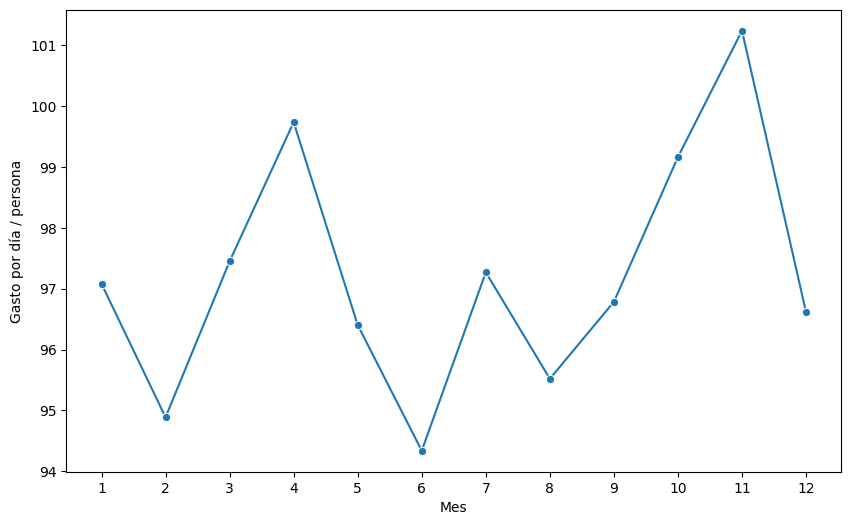

In [330]:
# Graficar la tendencia del gasto por día/persona según el mes de ingreso

plt.figure(figsize=(10,6))
sns.lineplot(data=gasto_por_mes, x='Mes_Ingreso', y='Gasto/p/d', marker='o')
plt.xlabel('Mes')
plt.ylabel('Gasto por día / persona')
plt.xticks(range(1,13))
plt.grid(False)
plt.show()

In [331]:
# Calcular el promedio de gasto por día/persona por temporada

gasto_por_temporada = df.groupby('Temporada')['Gasto/p/d'].mean().reset_index()
gasto_por_temporada

Temporada  Gasto/p/d
0      Alta  96.474066
1      Baja  96.001193
2     Media  99.208437

In [332]:
# Eliminar columnas no relevantes

cols_a_eliminar = [
    'FechaIngreso','FechaEgreso','Estudio','Otra Localidad','Otro Departamento','GastoAlojamiento'
]
df = df.drop(columns=[col for col in cols_a_eliminar if col in df.columns])

In [333]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63771 entries, 1 to 65332
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Lugar Ingreso                        63771 non-null  object 
 1   Transporte Internacional de Ingreso  63771 non-null  object 
 2   Pais                                 63771 non-null  object 
 3   Residencia                           63771 non-null  object 
 4   Motivo                               63771 non-null  object 
 5   Ocupacion                            63771 non-null  object 
 6   Localidad                            63758 non-null  object 
 7   Departamento                         63758 non-null  object 
 8   Alojamiento                          63771 non-null  object 
 9   TransporteLocal                      63771 non-null  object 
 10  Lugar Egreso                         63771 non-null  object 
 11  Transporte Internacional de Egres

In [334]:
print(f"Dataset limpio: {df.shape[0]} filas, media gasto/día = {round(df['Gasto/p/d'].mean(),2)}")

Dataset limpio: 63771 filas, media gasto/día = 97.07


In [335]:
# Conteo de nulos y valores únicos

print(f"\n Valores nulos: {df[col].isna().sum()}")


 Valores nulos: 0


### Dividir df original en df_train y df_test

In [336]:
# Dividir el df original en train y test 80/20

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [337]:
print("Shape de df_train:", df_train.shape)
print("Shape de df_test:", df_test.shape)

Shape de df_train: (51016, 24)
Shape de df_test: (12755, 24)


### Transformaciones en df_train

#### Lugar de Ingreso

Lugar por donde el turista ingresó a Uruguay.

In [338]:
# Lugar de Ingreso

lugaresI_principales = ['Colonia','Aeropuerto de Carrasco','Fray Bentos','Salto','Paysandú',
                       'Puerto de montevideo','Chuy','Rivera','Aeropuerto de Punta del Este']

df_train['Lugar Ingreso'] = df_train['Lugar Ingreso'].apply(lambda x: x if x in lugaresI_principales else 'Otros')

print(df_train['Lugar Ingreso'].unique())

['Colonia' 'Salto' 'Aeropuerto de Carrasco' 'Fray Bentos' 'Otros'
 'Puerto de montevideo' 'Chuy' 'Paysandú' 'Rivera'
 'Aeropuerto de Punta del Este']


#### Transporte Internacional de Ingreso

Medio de transporte internacional utilizado para ingresar a Uruguay.

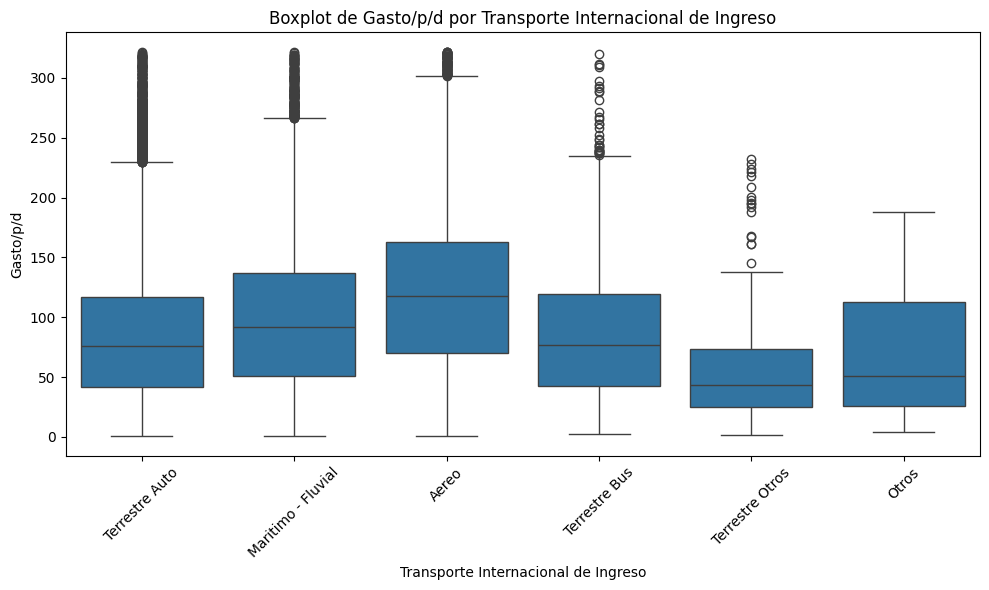

In [339]:
# Transporte Internacional de Ingreso

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_train,
    x='Transporte Internacional de Ingreso',
    y='Gasto/p/d',
    order=df_train['Transporte Internacional de Ingreso'].value_counts().index
)
plt.title('Boxplot de Gasto/p/d por Transporte Internacional de Ingreso')
plt.xlabel('Transporte Internacional de Ingreso')
plt.ylabel('Gasto/p/d')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [340]:
agrupacion_transporteI = {
    'Aereo': 'Aereo',
    'Maritimo - Fluvial': 'Maritimo',
    'Terrestre Auto': 'Terrestre',
    'Terrestre Bus': 'Terrestre',
    'Terrestre Otros': 'Terrestre',
    'Otros': 'Terrestre',  
}

df_train['Transporte Internacional de Ingreso'] = df_train['Transporte Internacional de Ingreso'].map(agrupacion_transporteI)

print(df_train['Transporte Internacional de Ingreso'].unique())

['Maritimo' 'Terrestre' 'Aereo']


#### Pais

Nacionalidad de turista que ingresó a Uruguay.

In [341]:
# Pais

tabla_pais = (
    df_train.groupby('Pais')['Gasto/p/d']
      .agg(['mean', 'median', 'min', 'max', 'count',
            lambda x: x.quantile(0.75) - x.quantile(0.25)])
      .reset_index()
)
tabla_pais.columns = ['Pais', 'Media', 'Mediana', 'Min', 'Max', 'Cantidad', 'Rango IQR']

tabla_pais = tabla_pais.sort_values('Media', ascending=False).reset_index(drop=True)

display(tabla_pais)

Pais       Media     Mediana        Min         Max  \
0            Paraguay  128.512855  125.055556   0.634687  318.545000   
1              Mexico  127.878866  123.064250   9.730000  315.435000   
2     Otro de America  127.077133  120.479143   7.912500  319.741667   
3               Chile  119.224101  117.172500   2.515000  313.090000   
4   Otro pais de Asia  118.623379  115.541429   9.520000  312.540000   
5            Colombia  118.333189  114.658333   2.500000  306.290000   
6               Japon  118.154404  107.750000   8.571429  308.590833   
7              Canada  115.424992  115.935000  18.500000  280.060000   
8        Gran Bretaña  114.413275  106.983333   2.384699  291.000000   
9              Brasil  113.708556  105.366875   1.818571  321.213333   
10             EE.UU.  112.222953  102.355667   1.419333  321.600000   
11            Ecuador  110.842039  102.561000   7.720000  272.500000   
12             Italia  106.551531   85.762143   8.333333  321.900000   
13     Otro de Europa  105.926406   97.375000   2.500000  297.916667   
14             Suecia  105.185449  110.687805  12.844792  226.103500   
15   Africa u Oceania  104.689530   95.719167   3.333333  212.890000   
16               Peru  104.270828   95.842500   3.333333  308.020000   
17              Suiza  102.284938   92.500000  14.539286  266.993333   
18              China   99.094604  100.563333  10.000000  218.600000   
19          Argentina   98.158351   90.795000   0.380625  321.822500   
20           Alemania   97.993283   87.290000   6.427500  300.000000   
21            Francia   94.598359   80.325000   2.930000  321.983000   
22            Bolivia   94.318212   84.875833   5.030000  230.370000   
23             España   93.540682   80.325000   2.615000  314.770000   
24             Israel   89.787235   72.500000   4.734815  272.856000   
25          Venezuela   89.325741   81.666667   6.445000  303.255000   
26               Cuba   87.309682   82.305333  27.520000  175.056667   
27            Uruguay   57.770776   48.293438   1.397778  319.225000   

    Cantidad  Rango IQR  
0       1135  80.616485  
1        278  90.230508  
2        728  86.341868  
3       1430  79.991729  
4         85  55.692500  
5        365  82.972500  
6         22  76.772471  
7        141  67.512167  
8        101  81.013667  
9       9679  91.136667  
10       682  85.939375  
11       198  89.746500  
12       200  96.292458  
13       533  73.912000  
14        32  85.094916  
15        80  71.233571  
16       408  79.707540  
17        69  71.878182  
18        27  45.141083  
19     25265  85.019167  
20       227  72.538611  
21       177  77.599643  
22       100  81.560000  
23       559  94.287443  
24        63  77.471970  
25       327  63.367750  
26        36  66.354679  
27      8069  49.324667

In [342]:
paises = [
    'Uruguay', 'Argentina', 'Brasil', 'Chile', 'Paraguay', 'Otro de America'
]
paises_otro_america = [
    'Mexico', 'Canada', 'Colombia', 'EE.UU.', 'Ecuador', 'Peru', 'Bolivia', 'Cuba', 'Venezuela'
]
paises_resto_mundo = [
    'Otro pais de Asia', 'Japon', 'China', 'Israel', 'Africa u Oceania'
]
paises_europa = [
    'Gran Bretaña', 'Suecia', 'Italia', 'Suiza', 'Francia', 'Alemania', 'España', 'Otro de Europa'
]

def agrupar_pais(pais):
    if pais in paises:
        return pais
    elif pais in paises_otro_america:
        return 'Otro de America'
    elif pais in paises_resto_mundo:
        return 'Resto del mundo'
    elif pais in paises_europa:
        return 'Europa'
    else:
        return pais

df_train['Pais'] = df_train['Pais'].apply(agrupar_pais)

print(df_train['Pais'].unique())

['Argentina' 'Chile' 'Paraguay' 'Brasil' 'Uruguay' 'Europa'
 'Otro de America' 'Resto del mundo']


#### Residencia

Lugar de residencia de turista que ingresó a Uruguay.

In [343]:
# Residencia

map_residencia_a_pais = {
    
    'Buenos Aires':'Argentina','Rosario':'Argentina','Cordoba':'Argentina','Corrientes':'Argentina',
    'Pcia. Enre Rios':'Argentina','Otras Pcias. Argentinas':'Argentina','Otros Pcia. Bs. As.':'Argentina',
    'Otros Pcia. Santa Fe':'Argentina','Otras Pcia Cordoba':'Argentina',

    'San Pablo':'Brasil','Otros San Pablo':'Brasil','Rio de Janeiro':'Brasil','Porto Alegre':'Brasil',
    'Santa Catarina':'Brasil','Pelotas - Rio Grande':'Brasil','Rio Grande':'Brasil','Otra  ciudades de Brasil':'Brasil',
    
    'Paraguay':'Paraguay',
    
    'Chile':'Chile',
    
    'Mexico':'Mexico',
    
    'Colombia':'Colombia',
    
    'Peru':'Peru',
    
    'EEUU - Canada':'EEUU-Canada',
    
    'Reino Unido':'Reino Unido','Alemanai':'Alemania','España':'España','Europa':'Europa',
    
    'Otras ciudades America':'Otro America','Otras ciudades Sudamerica':'Otro Sudamerica',
    'Ciudades de Asia':'Asia','Ciudades Africa y Oceania':'Africa-Oceania',
    
    'Sin Datos':'Sin Datos'
}
df_train['Residencia'] = df_train['Residencia'].map(map_residencia_a_pais)

print(df_train['Residencia'].unique())

['Argentina' 'Chile' 'Paraguay' 'Brasil' 'España' 'Europa' 'Mexico'
 'EEUU-Canada' 'Otro Sudamerica' 'Asia' 'Otro America' 'Colombia' 'Peru'
 'Reino Unido' 'Africa-Oceania' 'Alemania' 'Sin Datos']


#### Motivo

Motivo del ingreso a Uruguay.

In [344]:
# Motivo

df_train['Motivo'] = df_train['Motivo'].replace(
    {'MICE':'Trabajo / Profesional / MICE','Trabajo / Profesional':'Trabajo / Profesional / MICE',
     'Estudios':'Otros','Religioso':'Otros','Compras':'Otros','Salud / wellness':'Otros'}
)

print(df_train['Motivo'].unique())

['Ocio y vacaciones' 'Visita a familiares y amigos'
 'Trabajo / Profesional / MICE' 'Otros' 'Segunda Residencia' 'Transito']


#### Ocupación

Ocupación o profesión del turista que ingresó a Uruguay.

In [345]:
# Ocupación

tabla_ocupacion = (
    df_train.groupby('Ocupacion')['Gasto/p/d']
      .agg(['mean', 'median', 'min', 'max', 'count',
            lambda x: x.quantile(0.75) - x.quantile(0.25)])
      .reset_index()
)
tabla_ocupacion.columns = ['Ocupacion', 'Media', 'Mediana', 'Min', 'Max', 'Cantidad', 'Rango IQR']

tabla_ocupacion = tabla_ocupacion.sort_values('Media', ascending=False).reset_index(drop=True)

display(tabla_ocupacion)

Ocupacion       Media     Mediana  \
0                                   Director, gerente  132.236863  125.874583   
1                        Patron, Com, Ind, Prod Agrop  118.663828  109.583542   
2                     Prof, Tecnico, Docente, Artista  116.164763  114.100000   
3                           Profesional independiente  111.011183  101.723795   
4                             Profesional dependiente  106.292671   97.695000   
5                             Desconocido / Sin Datos   98.351094   84.652389   
6                                            Rentista   97.553155   87.790500   
7                         Empl. Adm, Cajero, Vendedor   93.536714   85.598125   
8                               Jubilado, Pensionista   91.451481   81.240000   
9                                 Funcionario Publico   90.768436   82.466667   
10                                          Sin Datos   88.303634   75.995714   
11                   Deportista, Entrenador, Juez Dep   85.990771   77.748333   
12                                              Otros   83.516490   65.400417   
13                           Trabajador Independiente   82.255936   70.963889   
14  Militar, policia, Aduanero, Insp, bombero, Mar...   80.779412   76.982500   
15                             Trabajador dependiente   77.535026   65.445000   
16                                         Estudiante   72.683267   62.257773   
17                           Jefe, Capataz, Encargado   70.908809   61.452583   
18                                         Desocupado   67.585636   49.940000   
19                                        Ama de casa   64.594739   48.649167   
20                    Obrero esp, Conductor, Artesano   60.201277   50.886667   
21                         Otra situacion Inactividad   58.399134   54.151250   
22                     Trabajador sin especializacion   55.020460   47.371667   
23                                          Religioso   53.624174   38.023333   
24                Mozo, Portero, Serv Dom, Otros Serv   50.468399   43.767857   
25                             Trabajador Agro, Pesca   45.098570   33.333333   

          Min         Max  Cantidad  Rango IQR  
0    2.500000  320.600000      1012  88.340521  
1    0.590000  321.900000      7000  87.884375  
2    0.380625  321.983000      9053  82.458000  
3    1.581636  321.069167      2200  98.292762  
4    1.686667  320.000000      3453  92.556000  
5    3.333333  318.166667       372  67.668357  
6   14.664000  310.930000       162  62.713823  
7    1.545000  321.822500      8000  83.944985  
8    1.397778  321.035000      3831  83.451028  
9    2.000000  301.000000       843  72.391733  
10   4.761905  282.182000       165  71.700000  
11   2.500000  311.630714       492  62.560656  
12   5.280000  295.930000       159  84.674649  
13   2.500000  319.295000      1634  68.007646  
14   2.500000  312.510000       424  60.630881  
15   0.634687  320.116667      5075  70.924167  
16   1.338750  292.885000      1624  57.406190  
17   2.500000  319.250000      1750  61.515375  
18   5.000000  262.447368       127  53.485500  
19   3.233182  320.953333       862  58.991375  
20   0.691711  311.500000      2023  51.371893  
21  14.020000  172.000000        19  35.633158  
22   5.515000  168.850000       114  45.049792  
23   2.513333  233.000000       161  45.642167  
24   3.333333  238.000000       300  40.243750  
25   2.500000  162.500000       161  47.715000

In [346]:
ocupacion_categoria = {
    
    "Director, gerente": "Profesionales y Patrones",
    "Patron, Com, Ind, Prod Agrop": "Profesionales y Patrones",
    "Prof, Tecnico, Docente, Artista": "Profesionales y Patrones",
    "Profesional independiente": "Profesionales y Patrones",
    "Profesional dependiente": "Profesionales y Patrones",

    "Empl. Adm, Cajero, Vendedor": "Empleados A",
    "Funcionario Publico": "Empleados A",
    "Deportista, Entrenador, Juez Dep": "Empleados A",
    "Trabajador Independiente": "Empleados A",
    "Militar, policia, Aduanero, Insp, bombero, Marinero": "Empleados A",

    "Trabajador dependiente": "Empleados B",
    "Jefe, Capataz, Encargado": "Empleados B",
    "Obrero esp, Conductor, Artesano": "Empleados B",
 
    "Rentista": "Inactivos con ingresos",
    "Jubilado, Pensionista": "Inactivos con ingresos",
 
    "Estudiante": "No remunerados",
    "Ama de casa": "No remunerados",

    "Mozo, Portero, Serv Dom, Otros Serv": "Otros",
    "Trabajador Agro, Pesca": "Otros",
    "Desocupado": "Otros",
    "Trabajador sin especializacion": "Otros",
    "Otra situacion Inactividad": "Otros",
    "Desconocido / Sin Datos": "Otros",
    "Sin Datos": "Otros",
    "Religioso": "Otros",
    "Otros": "Otros"
}

df_train["Ocupacion"] = df_train["Ocupacion"].map(ocupacion_categoria)
print(df_train['Ocupacion'].unique())

['Profesionales y Patrones' 'Otros' 'Empleados A' 'Empleados B'
 'Inactivos con ingresos' 'No remunerados']


#### Localidad

Destino principal elegido por el turista que ingresó a Uruguay.

In [347]:
# Localidad

df_train['Localidad'] = df_train['Localidad'].replace(to_replace=['Sin Datos','Otros',''],value='Otros').fillna('Otros')
print(df_train['Localidad'].unique())

['Montevideo' 'Salto' 'Punta del Este' 'La Paloma' 'Punta Colorada'
 'Termas del Arapey' 'Otros' 'Piriapolis' 'Paysandu' 'Termas del Dayman'
 'Colonia del Sacramento' 'Young' 'La Floresta' 'Treinta y Tres'
 'Pan de Azucar' 'Fray Bentos' 'Punta del Diablo' 'Las Cañas' 'Mercedes'
 'Termas de Guaviyu' 'La Barra' 'Punta Ballena' 'Barra del Chuy'
 'Transito' 'Atlantida' 'San Luis' 'Villa Serrana' 'Carmelo' 'Bella Vista'
 'Rivera' 'Maldonado' 'Ciudad de la Costa' 'La Pedrera' 'Jose Ignacio'
 'Colonia Valdense' 'Minas' 'Fortaleza Santa Teresa' 'Parque del Plata'
 'San Javier' 'Pinamar' 'Las Toscas' 'Nueva Palmira' 'La Tuna' 'Melo'
 'Trinidad' 'Santa Lucia' 'Las Piedras' 'Jaugueriberry' 'La Charqueada'
 'San Jose' 'Playa Hermosa' 'San Gregorio de Polanco' 'Belen' 'Artigas'
 'Neptunia' 'Artilleros, El Ensueño, Santa Ana' 'Nuevo Berlin'
 'Casablanca' 'Bella Union' 'San Carlos' 'Acegua' 'Kiyu' 'El Chorro'
 'Solis' 'Garzon' 'La Concordia' 'Nueva helvecia' 'La Agraciada'
 'Laguna Merin' 'Tacuarembo

In [348]:
tabla_localidad = (
    df_train.groupby('Localidad')['Gasto/p/d']
      .agg(['mean', 'median', 'min', 'max', 'count',
            lambda x: x.quantile(0.75) - x.quantile(0.25)])
      .reset_index()
)
tabla_localidad .columns = ['Localidad', 'Media', 'Mediana', 'Min', 'Max', 'Cantidad', 'Rango IQR']

tabla_localidad  = tabla_localidad .sort_values('Cantidad', ascending=False).reset_index(drop=True)

print((tabla_localidad).head(9))

                Localidad       Media     Mediana       Min       Max  \
0              Montevideo  108.635204  107.339896  1.000000  321.9830   
1          Punta del Este  151.586794  149.908750  0.590000  321.8225   
2  Colonia del Sacramento   90.948824   87.560000  2.000000  311.8900   
3                Transito   49.529400   40.405000  1.394000  278.2950   
4       Termas del Dayman   83.412390   90.476562  6.554000  261.4100   
5              Piriapolis   94.915334   93.483741  1.581636  318.5450   
6                   Salto   58.712504   48.635208  3.655000  270.0000   
7                   Otros   51.106225   43.952097  1.338750  313.1325   
8                Paysandu   56.707101   44.535000  1.885000  300.0000   

   Cantidad  Rango IQR  
0     17050  82.210714  
1      7999  97.191935  
2      4093  70.505000  
3      2168  62.483750  
4      1922  51.616708  
5      1458  49.813645  
6      1304  46.950625  
7      1098  41.774062  
8      1015  52.819167  


In [349]:
loc_principales = ['Montevideo','Punta del Este','Colonia del Sacramento','Transito','Termas del Dayman','Piriapolis', 'Salto', 'Paysandu']

df_train['Localidad'] = df_train['Localidad'].apply(lambda x: x if x in loc_principales else 'Otros')

print(df_train['Localidad'].unique())

['Montevideo' 'Salto' 'Punta del Este' 'Otros' 'Piriapolis' 'Paysandu'
 'Termas del Dayman' 'Colonia del Sacramento' 'Transito']


#### Departamento

Departamento destino elegido por el turista que ingresó a Uruguay.

In [350]:
# Departamento

deptos_principales = ['Colonia','Montevideo','Maldonado','Salto','Canelones','Transito']

df_train['Departamento'] = df_train['Departamento'].apply(lambda x: x if x in deptos_principales else 'Otros').fillna('Otros')

print(df_train['Departamento'].unique())

['Montevideo' 'Salto' 'Maldonado' 'Otros' 'Colonia' 'Canelones' 'Transito']


#### Alojamiento

Alojamiento principal elegido por el turista que ingresó a Uruguay.

In [351]:
# Alojamiento

tabla_alojamiento = (
    df_train.groupby('Alojamiento')['Gasto/p/d']
      .agg(['mean', 'median', 'min', 'max', 'count',
            lambda x: x.quantile(0.75) - x.quantile(0.25)])
      .reset_index()
)
tabla_alojamiento.columns = ['Alojamiento', 'Media', 'Mediana', 'Min', 'Max', 'Cantidad', 'Rango IQR']

tabla_alojamiento = tabla_alojamiento.sort_values('Cantidad', ascending=False).reset_index(drop=True)

display(tabla_alojamiento)

Alojamiento       Media     Mediana  \
0      Vivienda familiares/amigos residentes   58.856859   49.586667   
1                      Hotel sin categorizar  131.550045  122.074583   
2                          Hotel 3 estrellas  134.007755  129.623333   
3                         Vivienda arrendada  100.369830   85.914083   
4                                    Ninguno   55.561506   41.280000   
5                          Hotel 4 estrellas  159.520515  152.351667   
6                            Vivienda propia  125.371576  116.516693   
7   Vivienda familiares/amigos no residentes   75.587905   64.289470   
8                      Hotel 1 y 2 estrellas  105.259216   99.671000   
9                             Hotel/Albergue   77.653700   72.000000   
10                         Cabañas/Bungalows   61.042145   55.250388   
11         Vivienda arrendada por plataforma   99.226553   92.561458   
12                              Appart Hotel  117.632045  107.154167   
13                         Hotel 5 estrellas  174.876837  168.940000   
14                                   Camping   32.947691   30.594350   
15                                     Otros   53.749322   45.340000   
16                                Motor Home   56.634727   50.774583   
17                         Tiempo Compartido  113.990814  104.909091   
18                        Estancia Turistica   85.899964   74.000000   
19                      Barco, Yate, Crucero   65.959680   56.349875   
20                           Bed y Breakfast   99.924908   86.000000   
21                                 Sin Datos   48.799074   52.050000   

          Min         Max  Cantidad  Rango IQR  
0    0.590000  320.116667     15417  50.491944  
1    2.066250  321.900000      7278  79.024256  
2    4.428333  321.645000      6836  54.490000  
3    2.325000  320.702500      3654  74.147665  
4    1.394000  315.435000      3628  60.305000  
5    5.314000  321.822500      3435  66.167917  
6    8.935000  319.295000      3050  82.490509  
7    0.380625  313.155000      1208  58.319167  
8   10.883333  314.065000      1141  53.702187  
9    7.601810  317.235000      1109  37.888442  
10   9.380000  288.252143      1108  29.178194  
11   2.384699  282.182000       866  65.272708  
12   8.516667  290.300000       655  41.943036  
13   5.256667  321.983000       493  89.937667  
14   2.677000  124.722500       430  20.315675  
15   1.581636  233.000000       378  37.342690  
16   6.566094  217.666667       144  41.949390  
17   7.857143  303.038077        71  68.180536  
18   7.207500  314.272727        41  42.582310  
19   1.490405  186.052632        38  40.226862  
20  19.428571  225.455000        27  69.812500  
21   2.136667  100.000000         9  23.686667

In [352]:
mapa_alojamiento = {
    
    'Vivienda familiares/amigos residentes': 'Vivienda familiares/amigos',
    'Vivienda familiares/amigos no residentes': 'Vivienda familiares/amigos',
 
    'Hotel 4 estrellas': 'Hoteles 4 y 5 estrellas',
    'Hotel 5 estrellas': 'Hoteles 4 y 5 estrellas',
 
    'Hotel sin categorizar': 'Otros Hoteles',
    'Hotel 3 estrellas': 'Otros Hoteles',
    'Hotel 1 y 2 estrellas': 'Otros Hoteles',
    'Appart Hotel': 'Otros Hoteles',
    'Hotel/Albergue': 'Otros Hoteles',
 
    'Ninguno': 'Otros',
    'Camping': 'Otros',
    'Motor Home': 'Otros',
    'Tiempo Compartido': 'Otros',
    'Barco, Yate, Crucero': 'Otros',
    'Estancia Turistica': 'Otros',
    'Bed y Breakfast': 'Otros',
    'Sin Datos': 'Otros',
    'Cabañas/Bungalows': 'Otros',
    'Otros': 'Otros',
 
    'Vivienda propia': 'Vivienda propia',
 
    'Vivienda arrendada': 'Vivienda arrendada',
    'Vivienda arrendada por plataforma': 'Vivienda arrendada'
}

df_train['Alojamiento'] = df_train['Alojamiento'].map(mapa_alojamiento)
 
print(df_train['Alojamiento'].unique())

['Otros Hoteles' 'Vivienda familiares/amigos' 'Hoteles 4 y 5 estrellas'
 'Vivienda arrendada' 'Vivienda propia' 'Otros']


#### Transporte Local

Transporte utilizado durante la estadía en Uruguay.

In [353]:
# Transporte Local

transp_principales = ['Auto propio','Taxi - Bus','Auto familiares / amigos','Ninguno']

df_train['TransporteLocal'] = df_train['TransporteLocal'].apply(lambda x: x if x in transp_principales else 'Otros').fillna('Otros')

print(df_train['TransporteLocal'].unique())

['Taxi - Bus' 'Auto propio' 'Ninguno' 'Otros' 'Auto familiares / amigos']


#### Lugar de Egreso

Lugar por donde el turista egresó de Uruguay.

In [354]:
# Lugar de Egreso

lugaresE_principales = ['Colonia','Aeropuerto de Carrasco','Fray Bentos','Salto','Paysandú',
                       'Puerto de montevideo','Chuy','Rivera','Aeropuerto de Punta del Este']

df_train['Lugar Egreso'] = df_train['Lugar Egreso'].apply(lambda x: x if x in lugaresE_principales else 'Otros')

print(df_train['Lugar Egreso'].unique())

['Colonia' 'Salto' 'Aeropuerto de Carrasco' 'Fray Bentos' 'Otros'
 'Puerto de montevideo' 'Chuy' 'Paysandú' 'Aeropuerto de Punta del Este'
 'Rivera']


#### Transporte Internacional de Egreso

Medio de transporte internacional utilizado para egresar de Uruguay.

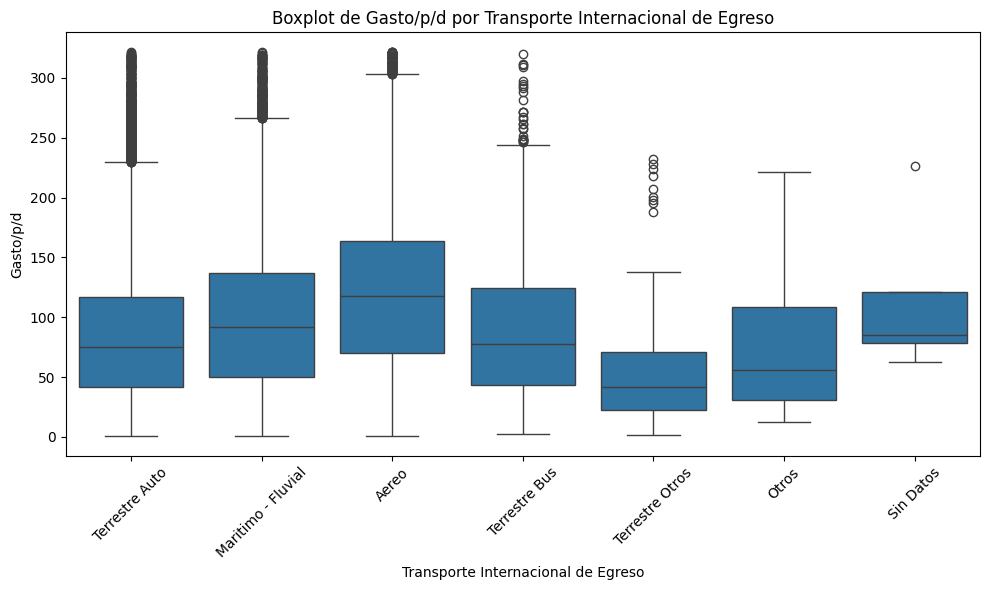

In [355]:
# Transporte Internacional de Egreso

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_train,
    x='Transporte Internacional de Egreso',
    y='Gasto/p/d',
    order=df_train['Transporte Internacional de Egreso'].value_counts().index
)
plt.title('Boxplot de Gasto/p/d por Transporte Internacional de Egreso')
plt.xlabel('Transporte Internacional de Egreso')
plt.ylabel('Gasto/p/d')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [356]:
agrupacion_transporteE = {
    'Aereo': 'Aereo',
    'Maritimo - Fluvial': 'Maritimo',
    'Terrestre Auto': 'Terrestre',
    'Terrestre Bus': 'Terrestre',
    'Terrestre Otros': 'Terrestre',
    'Otros': 'Terrestre',       
    'Sin Datos': 'Terrestre'     
}

df_train['Transporte Internacional de Egreso'] = df_train['Transporte Internacional de Egreso'].map(agrupacion_transporteE)

print(df_train['Transporte Internacional de Egreso'].unique())

['Maritimo' 'Terrestre' 'Aereo']


#### Tipo de Viaje

Variable creada a partir de la concatenación de Motivo + Alojamiento, luego de las agrupaciones realizadas a ambas variables.

In [357]:
df_train["Tipo_Viaje"] = df_train["Motivo"] + "_" + df_train["Alojamiento"]
df_train["Tipo_Viaje"].unique()

array(['Ocio y vacaciones_Otros Hoteles',
       'Visita a familiares y amigos_Vivienda familiares/amigos',
       'Ocio y vacaciones_Hoteles 4 y 5 estrellas',
       'Trabajo / Profesional / MICE_Otros Hoteles',
       'Ocio y vacaciones_Vivienda arrendada', 'Otros_Vivienda arrendada',
       'Segunda Residencia_Vivienda propia', 'Ocio y vacaciones_Otros',
       'Trabajo / Profesional / MICE_Vivienda familiares/amigos',
       'Ocio y vacaciones_Vivienda familiares/amigos',
       'Ocio y vacaciones_Vivienda propia',
       'Trabajo / Profesional / MICE_Hoteles 4 y 5 estrellas',
       'Trabajo / Profesional / MICE_Otros',
       'Visita a familiares y amigos_Otros Hoteles', 'Transito_Otros',
       'Otros_Vivienda familiares/amigos', 'Otros_Otros Hoteles',
       'Visita a familiares y amigos_Vivienda arrendada',
       'Transito_Otros Hoteles', 'Otros_Otros',
       'Visita a familiares y amigos_Hoteles 4 y 5 estrellas',
       'Visita a familiares y amigos_Vivienda propia',
      

In [358]:
print(df_train.shape)

(51016, 25)


In [359]:
list(df_train.columns)

['Lugar Ingreso',
 'Transporte Internacional de Ingreso',
 'Pais',
 'Residencia',
 'Motivo',
 'Ocupacion',
 'Localidad',
 'Departamento',
 'Alojamiento',
 'TransporteLocal',
 'Lugar Egreso',
 'Transporte Internacional de Egreso',
 'Destino',
 'Estadia',
 'Gente',
 'Gasto/p/d',
 'Mes_Ingreso',
 'Mes_Egreso',
 'Quarter_Year_Ingreso',
 'Quarter_Year_Egreso',
 'Temporada',
 'Gasta en Alojamiento?',
 'Es Transito?',
 'Personas_Dia',
 'Tipo_Viaje']

In [360]:
# Exportar el DataFrame a un archivo Excel

df_train.to_excel("df_train.xlsx", index=False)

### Aplicar transformaciones a df_test

In [361]:
# Función que aplica mapeos a df_test

def aplicar_mapeos_al_df(df_input):
    dfc = df_input.copy()
    dfc['Lugar Ingreso'] = dfc['Lugar Ingreso'].apply(lambda x: x if x in lugaresI_principales else 'Otros')
    dfc['Transporte Internacional de Ingreso'] = dfc['Transporte Internacional de Ingreso'].map(agrupacion_transporteI).fillna('Terrestre')
    dfc['Pais'] = dfc['Pais'].apply(agrupar_pais)
    dfc['Residencia'] = dfc['Residencia'].map(map_residencia_a_pais).fillna('Sin Datos')
    dfc['Motivo'] = dfc['Motivo'].replace(
        {'MICE':'Trabajo / Profesional / MICE','Trabajo / Profesional':'Trabajo / Profesional / MICE',
         'Estudios':'Otros','Religioso':'Otros','Compras':'Otros','Salud / wellness':'Otros'}
    ).fillna('Otros')
    dfc['Ocupacion'] = dfc['Ocupacion'].map(ocupacion_categoria).fillna('Otros')
    dfc['Localidad'] = dfc['Localidad'].replace(to_replace=['Sin Datos','Otros',''], value='Otros').fillna('Otros')
    dfc['Localidad'] = dfc['Localidad'].apply(lambda x: x if x in loc_principales else 'Otros')
    dfc['Departamento'] = dfc['Departamento'].apply(lambda x: x if x in deptos_principales else 'Otros').fillna('Otros')
    dfc['Alojamiento'] = dfc['Alojamiento'].map(mapa_alojamiento).fillna('Otros')
    dfc['TransporteLocal'] = dfc['TransporteLocal'].apply(lambda x: x if x in transp_principales else 'Otros').fillna('Otros')
    dfc['Lugar Egreso'] = dfc['Lugar Egreso'].apply(lambda x: x if x in lugaresE_principales else 'Otros')
    dfc['Transporte Internacional de Egreso'] = dfc['Transporte Internacional de Egreso'].map(agrupacion_transporteE).fillna('Terrestre')
    return dfc

df_test = aplicar_mapeos_al_df(df_test)

In [362]:
df_test["Tipo_Viaje"] = df_test["Motivo"] + "_" + df_test["Alojamiento"]
df_test["Tipo_Viaje"].unique()

array(['Transito_Otros Hoteles',
       'Visita a familiares y amigos_Hoteles 4 y 5 estrellas',
       'Visita a familiares y amigos_Vivienda familiares/amigos',
       'Ocio y vacaciones_Vivienda familiares/amigos',
       'Segunda Residencia_Vivienda propia',
       'Trabajo / Profesional / MICE_Otros Hoteles',
       'Ocio y vacaciones_Otros Hoteles',
       'Trabajo / Profesional / MICE_Hoteles 4 y 5 estrellas',
       'Transito_Otros', 'Ocio y vacaciones_Hoteles 4 y 5 estrellas',
       'Ocio y vacaciones_Otros', 'Ocio y vacaciones_Vivienda arrendada',
       'Ocio y vacaciones_Vivienda propia',
       'Visita a familiares y amigos_Otros Hoteles',
       'Trabajo / Profesional / MICE_Vivienda arrendada',
       'Trabajo / Profesional / MICE_Vivienda familiares/amigos',
       'Trabajo / Profesional / MICE_Otros',
       'Otros_Hoteles 4 y 5 estrellas', 'Transito_Vivienda arrendada',
       'Otros_Vivienda propia', 'Visita a familiares y amigos_Otros',
       'Otros_Vivienda famili

In [363]:
print(df_test.shape)

(12755, 25)


In [364]:
list(df_test.columns)

['Lugar Ingreso',
 'Transporte Internacional de Ingreso',
 'Pais',
 'Residencia',
 'Motivo',
 'Ocupacion',
 'Localidad',
 'Departamento',
 'Alojamiento',
 'TransporteLocal',
 'Lugar Egreso',
 'Transporte Internacional de Egreso',
 'Destino',
 'Estadia',
 'Gente',
 'Gasto/p/d',
 'Mes_Ingreso',
 'Mes_Egreso',
 'Quarter_Year_Ingreso',
 'Quarter_Year_Egreso',
 'Temporada',
 'Gasta en Alojamiento?',
 'Es Transito?',
 'Personas_Dia',
 'Tipo_Viaje']

## Preparación de train y test

In [365]:
# Preparar X_train, X_test, y_train, y_test

y_train = df_train['Gasto/p/d']
X_train = df_train.drop(columns=['Gasto/p/d'])

y_test = df_test['Gasto/p/d']
X_test = df_test.drop(columns=['Gasto/p/d'])

In [366]:
# Columnas categóricas

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Rellenar NaN y convertir a string

for col in categorical_cols:
    X_train[col] = X_train[col].fillna("missing").astype(str)
    X_test[col]  = X_test[col].fillna("missing").astype(str)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print("Variables categóricas:", categorical_cols)
print("Variables numéricas:", numeric_cols)

Variables categóricas: ['Lugar Ingreso', 'Transporte Internacional de Ingreso', 'Pais', 'Residencia', 'Motivo', 'Ocupacion', 'Localidad', 'Departamento', 'Alojamiento', 'TransporteLocal', 'Lugar Egreso', 'Transporte Internacional de Egreso', 'Destino', 'Temporada', 'Gasta en Alojamiento?', 'Es Transito?', 'Tipo_Viaje']
Variables numéricas: ['Estadia', 'Gente', 'Mes_Ingreso', 'Mes_Egreso', 'Quarter_Year_Ingreso', 'Quarter_Year_Egreso', 'Personas_Dia']


In [367]:
df_train.dtypes

Lugar Ingreso                           object
Transporte Internacional de Ingreso     object
Pais                                    object
Residencia                              object
Motivo                                  object
Ocupacion                               object
Localidad                               object
Departamento                            object
Alojamiento                             object
TransporteLocal                         object
Lugar Egreso                            object
Transporte Internacional de Egreso      object
Destino                                 object
Estadia                                  int64
Gente                                    int64
Gasto/p/d                              float64
Mes_Ingreso                              int32
Mes_Egreso                               int32
Quarter_Year_Ingreso                     int64
Quarter_Year_Egreso                      int64
Temporada                               object
Gasta en Aloj

In [368]:
df_test.dtypes

Lugar Ingreso                           object
Transporte Internacional de Ingreso     object
Pais                                    object
Residencia                              object
Motivo                                  object
Ocupacion                               object
Localidad                               object
Departamento                            object
Alojamiento                             object
TransporteLocal                         object
Lugar Egreso                            object
Transporte Internacional de Egreso      object
Destino                                 object
Estadia                                  int64
Gente                                    int64
Gasto/p/d                              float64
Mes_Ingreso                              int32
Mes_Egreso                               int32
Quarter_Year_Ingreso                     int64
Quarter_Year_Egreso                      int64
Temporada                               object
Gasta en Aloj

In [369]:
# Definir función de Hit Rate

def hit_rate(y_real, y_pred, umbral):
    """
    Calcula el Hit Rate para un umbral relativo dado.
    umbral debe ser 0.10, 0.20, 0.30, etc.
    """
    return np.mean(np.abs(y_real - y_pred) / y_real <= umbral)

In [370]:
# Definir función de performance por grupo

def performance_por_grupo(df_test, y_real, y_pred, variable):
    
    df_eval = df_test.copy()
    df_eval["y_real"] = y_real
    df_eval["y_pred"] = y_pred
    df_eval["error_abs"] = np.abs(df_eval["y_real"] - df_eval["y_pred"])
    df_eval["error_rel"] = df_eval["error_abs"] / df_eval["y_real"]

    resultados = []

    for cat, grupo in df_eval.groupby(variable):
        mae = grupo["error_abs"].mean()
        rmse = np.sqrt(((grupo["y_real"] - grupo["y_pred"]) ** 2).mean())

        hit10 = (grupo["error_rel"] <= 0.10).mean()
        hit20 = (grupo["error_rel"] <= 0.20).mean()
        hit30 = (grupo["error_rel"] <= 0.30).mean()

        resultados.append({
            variable: cat,
            "MAE": mae,
            "RMSE": rmse,
            "Hit10": hit10,
            "Hit20": hit20,
            "Hit30": hit30
        })

    return pd.DataFrame(resultados).sort_values("MAE")

## Regresión Lineal

In [371]:
# Preprocesamiento

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model', LinearRegression())
])

In [372]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')
cv_mae_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
cv_rmse_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

print("Resultados de validación cruzada (5 folds):")
print(f"R² promedio:  {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")
print(f"MAE promedio: {-cv_mae_scores.mean():.4f} ± {cv_mae_scores.std():.4f}")
print(f"RMSE promedio: {-cv_rmse_scores.mean():.4f} ± {cv_rmse_scores.std():.4f}")

Resultados de validación cruzada (5 folds):
R² promedio:  0.5257 ± 0.0058
MAE promedio: 31.4114 ± 0.0423
RMSE promedio: 42.3391 ± 0.2042


### Train

In [373]:
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)

r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

print("\n Resultados en Train:")
print(f"R²:   {r2_train:.4f}")
print(f"MAE:  {mae_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")


 Resultados en Train:
R²:   0.5287
MAE:  31.31
RMSE: 42.21


### Test

In [374]:
y_pred = pipeline.predict(X_test)

umbrales = [0.10, 0.20, 0.30]

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n Resultados en Test:")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

for umbral in umbrales:
    hr = hit_rate(y_test, y_pred, umbral)
    print(f"Hit Rate {int(umbral*100)}%: {hr:.4f}")


 Resultados en Test:
R²:   0.5306
MAE:  31.28
RMSE: 42.27
Hit Rate 10%: 0.1960
Hit Rate 20%: 0.3810
Hit Rate 30%: 0.5323


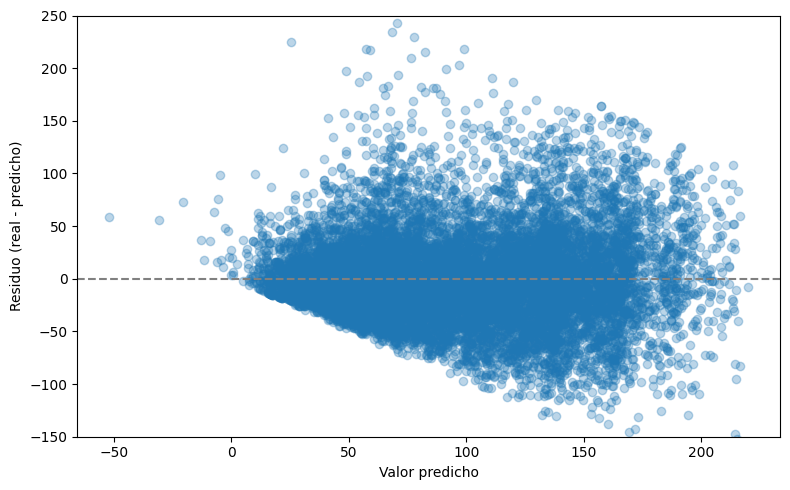

In [378]:
# Gráfico de residuos
 
residuals_lin = y_test - y_pred
 
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals_lin, alpha=0.3)
plt.axhline(0, linestyle='--', color='gray')
plt.ylim(-150, 250)
plt.xlabel("Valor predicho")
plt.ylabel("Residuo (real - predicho)")
plt.tight_layout()
plt.show()

 

### Feature Importance

In [379]:
ohe = pipeline.named_steps['preproc'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names = numeric_cols + cat_features

coefs = pipeline.named_steps['model'].coef_
coef_df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
coef_df = coef_df.sort_values(by='coef', ascending=False)


print("\n Top 15 coeficientes positivos:")
print(coef_df.head(15))

print("\n Top 15 coeficientes negativos:")
print(coef_df.tail(15))


 Top 15 coeficientes positivos:
                                         feature       coef
104                       Destino_Punta del Este  42.099604
101                           Destino_Montevideo  35.931314
141          Tipo_Viaje_Transito_Vivienda propia  28.812271
73           Alojamiento_Hoteles 4 y 5 estrellas  26.169770
49                               Motivo_Transito  25.566790
136  Tipo_Viaje_Transito_Hoteles 4 y 5 estrellas  22.762071
78                   Alojamiento_Vivienda propia  20.885170
38                             Residencia_Mexico  20.085333
66                        Departamento_Canelones  16.774519
68                        Departamento_Maldonado  16.754663
8     Lugar Ingreso_Aeropuerto de Punta del Este  15.600869
82                         TransporteLocal_Otros  15.564948
57              Localidad_Colonia del Sacramento  15.514432
97                               Destino_Colonia  15.181832
90                         Lugar Egreso_Paysandú  11.996616

 Top 1

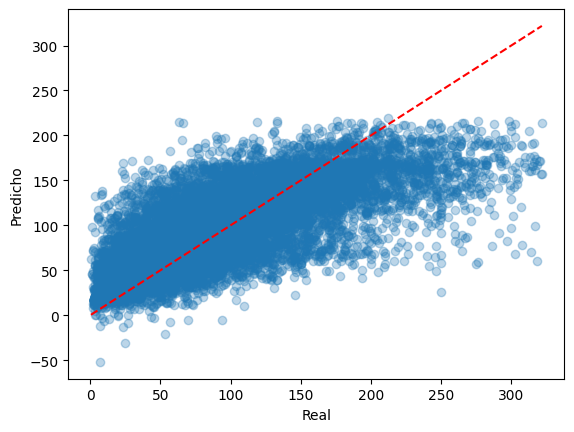

In [380]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [381]:
# Tabla ANOVA

categorical_cols = ['Lugar Ingreso', 'Transporte Internacional de Ingreso', 'Pais', 'Residencia', 
                    'Motivo', 'Ocupacion', 'Localidad', 'Departamento', 'Alojamiento', 
                    'TransporteLocal', 'Lugar Egreso', 'Transporte Internacional de Egreso', 
                    'Destino', 'Temporada', 'Gasta en Alojamiento?', 'Es Transito?', 'Tipo_Viaje']

numeric_cols = ['Estadia', 'Gente', 'Mes_Ingreso', 'Mes_Egreso', 'Quarter_Year_Ingreso', 
                'Quarter_Year_Egreso', 'Personas_Dia']

formula = "Q('Gasto/p/d') ~ " + " + ".join([f"C(Q('{col}'))" for col in categorical_cols]) + " + " + " + ".join(numeric_cols)

modelo = ols(formula, data=df_train).fit()

tabla_anova = anova_lm(modelo, typ=2)
tabla_anova = tabla_anova.sort_values(by='PR(>F)')
tabla_anova

sum_sq       df  \
C(Q('Tipo_Viaje'))                           5.959245e+06     34.0   
C(Q('TransporteLocal'))                      1.383948e+06      4.0   
C(Q('Destino'))                              1.393084e+06      8.0   
C(Q('Alojamiento'))                          1.225914e+06      5.0   
C(Q('Lugar Egreso'))                         1.136713e+06      9.0   
C(Q('Ocupacion'))                            6.948177e+05      5.0   
Gente                                        4.013682e+05      1.0   
C(Q('Motivo'))                               3.970461e+05      5.0   
Personas_Dia                                 3.068804e+05      1.0   
C(Q('Lugar Ingreso'))                        3.490595e+05      9.0   
C(Q('Localidad'))                            3.307227e+05      8.0   
C(Q('Residencia'))                           2.945261e+05     16.0   
C(Q('Departamento'))                         2.245352e+05      6.0   
C(Q('Gasta en Alojamiento?'))                1.592170e+05      1.0   
C(Q('Pais'))                                 1.269563e+05      7.0   
Estadia                                      3.576932e+04      1.0   
C(Q('Temporada'))                            2.120184e+04      2.0   
C(Q('Transporte Internacional de Egreso'))   1.957542e+04      2.0   
Quarter_Year_Ingreso                         1.713611e+03      1.0   
Mes_Ingreso                                  1.479770e+03      1.0   
Quarter_Year_Egreso                          1.277819e+03      1.0   
C(Q('Transporte Internacional de Ingreso'))  1.718802e+03      2.0   
C(Q('Es Transito?'))                         2.181772e+02      1.0   
Mes_Egreso                                   1.607968e+02      1.0   
Residual                                     9.088378e+07  50896.0   

                                                      F         PR(>F)  
C(Q('Tipo_Viaje'))                            98.154363   0.000000e+00  
C(Q('TransporteLocal'))                      193.756867  3.599924e-165  
C(Q('Destino'))                               97.517919  7.213725e-162  
C(Q('Alojamiento'))                          137.305293  3.909879e-145  
C(Q('Lugar Egreso'))                          70.730311  2.030123e-130  
C(Q('Ocupacion'))                             77.821232   1.368833e-81  
Gente                                        224.770954   1.057257e-50  
C(Q('Motivo'))                                44.470110   5.898845e-46  
Personas_Dia                                 171.856702   3.367054e-39  
C(Q('Lugar Ingreso'))                         21.719722   3.495215e-37  
C(Q('Localidad'))                             23.151083   9.698463e-36  
C(Q('Residencia'))                            10.308633   9.600668e-27  
C(Q('Departamento'))                          20.957064   1.088068e-24  
C(Q('Gasta en Alojamiento?'))                 89.163421   3.782967e-21  
C(Q('Pais'))                                  10.156718   9.057764e-13  
Estadia                                       20.031245   7.635209e-06  
C(Q('Temporada'))                              5.936642   2.642712e-03  
C(Q('Transporte Internacional de Egreso'))     5.481235   4.166644e-03  
Quarter_Year_Ingreso                           0.959643   3.272815e-01  
Mes_Ingreso                                    0.828689   3.626563e-01  
Quarter_Year_Egreso                            0.715594   3.975970e-01  
C(Q('Transporte Internacional de Ingreso'))    0.481275   6.179978e-01  
C(Q('Es Transito?'))                           0.122182   7.266815e-01  
Mes_Egreso                                     0.090048   7.641172e-01  
Residual                                            NaN            NaN

In [382]:
# Predicciones por grupo

y_pred_lin = pipeline.predict(X_test)

print("Regresión Lineal: desempeño por DESTINO ")
print(performance_por_grupo(df_test, y_test, y_pred_lin, "Destino"))

print("\n")

print("Regresión Lineal: desempeño por ALOJAMIENTO ")
print(performance_por_grupo(df_test, y_test, y_pred_lin, "Alojamiento"))

Regresión Lineal: desempeño por DESTINO 
            Destino        MAE       RMSE     Hit10     Hit20     Hit30
1      Costa de Oro  18.388361  24.042113  0.207273  0.374545  0.529091
3    Litoral Termal  20.456261  28.263330  0.200102  0.392037  0.537009
5             Otros  23.469241  33.024869  0.167196  0.300529  0.439153
2  Costas Oceanicas  23.685497  30.313399  0.182186  0.334008  0.512146
8          Transito  24.365731  32.941847  0.118966  0.231034  0.363793
6        Piriapolis  25.746525  33.523896  0.241379  0.454361  0.608519
0           Colonia  31.923672  44.508001  0.176033  0.355372  0.511570
4        Montevideo  35.015750  45.813838  0.201372  0.398486  0.541647
7    Punta del Este  44.156358  55.070254  0.214970  0.419930  0.591819


Regresión Lineal: desempeño por ALOJAMIENTO 
                  Alojamiento        MAE       RMSE     Hit10     Hit20  \
4  Vivienda familiares/amigos  26.681812  36.074707  0.134767  0.274074   
1                       Otros  30.262702  

## Catboost

### Búsqueda de mejores hiperparámetros

#### Train

In [398]:
model = CatBoostRegressor(
    eval_metric='RMSE',
    cat_features=categorical_cols,
    random_seed=42,
    verbose=100,
    od_type="Iter",
    od_wait=50
)

param_dist = {
    'depth': [1, 2, 3, 4, 5, 10],
    'learning_rate': [0.001, 0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [2000, 2500, 3000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.5, 0.7, 1.0],
    'min_data_in_leaf': [1, 5, 10, 20],
    'bootstrap_type': ['Bernoulli']
}

scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error'
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=500,
    scoring=scoring,
    refit='r2',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor R² obtenido:", random_search.best_score_)

cv_results = random_search.cv_results_

print("R² CV :", cv_results['mean_test_r2'])
print("MAE CV:", -cv_results['mean_test_mae'])
print("RMSE CV:", -cv_results['mean_test_rmse'])

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
0:	learn: 61.5915730	total: 82ms	remaining: 3m 24s
0:	learn: 61.5546473	total: 82.4ms	remaining: 3m 25s
0:	learn: 61.4266235	total: 88.4ms	remaining: 3m 40s
0:	learn: 61.4861244	total: 88.6ms	remaining: 3m 41s
0:	learn: 61.2602703	total: 88.7ms	remaining: 3m 41s
0:	learn: 59.9348788	total: 116ms	remaining: 3m 52s
0:	learn: 60.1296068	total: 123ms	remaining: 4m 5s
0:	learn: 60.1717777	total: 136ms	remaining: 4m 31s
100:	learn: 59.8554399	total: 845ms	remaining: 20.1s
100:	learn: 59.9681112	total: 1.01s	remaining: 24s
100:	learn: 59.9949202	total: 1.05s	remaining: 25s
100:	learn: 59.6412465	total: 1.04s	remaining: 24.8s
100:	learn: 59.9096571	total: 1.11s	remaining: 26.3s
200:	learn: 58.4451752	total: 1.72s	remaining: 19.6s
200:	learn: 58.5632004	total: 1.9s	remaining: 21.7s
200:	learn: 58.2715496	total: 1.93s	remaining: 22.1s
200:	learn: 58.5427586	total: 1.94s	remaining: 22.2s
200:	learn: 58.4962809	total: 2.03s	remaining:

#### Test

In [399]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

umbrales = [0.10, 0.20, 0.30]

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(" Evaluación en test")
print("R²:", round(r2, 2))
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

for umbral in umbrales:
    hr = hit_rate(y_test, y_pred, umbral)
    print(f"Hit Rate {int(umbral*100)}%: {hr:.4f}")

 Evaluación en test
R²: 0.64
MAE: 26.24
RMSE: 36.92
Hit Rate 10%: 0.2515
Hit Rate 20%: 0.4535
Hit Rate 30%: 0.6042


### Mejores parámetros

#### Train

In [383]:
model = CatBoostRegressor(
    eval_metric='RMSE',
    cat_features=categorical_cols,
    random_seed=42,
    verbose=100,
    od_type="Iter",
    od_wait=50
)

param_dist = {
    'depth': [10],
    'learning_rate': [0.03],
    'l2_leaf_reg': [1],
    'iterations': [2000],  
    'subsample': [1.0],
    'colsample_bylevel': [0.5],
    'min_data_in_leaf': [5],
    'bootstrap_type': ['Bernoulli']
}

scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error'
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=500,
    scoring=scoring,
    refit='r2',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor R² obtenido:", random_search.best_score_)

cv = random_search.cv_results_

print("R² promedio en CV:", cv['mean_test_r2'].mean())
print("MAE promedio en CV:", -cv['mean_test_mae'].mean())
print("RMSE promedio en CV:", -cv['mean_test_rmse'].mean())


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=500. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 60.6046556	total: 151ms	remaining: 5m 2s
0:	learn: 60.6686428	total: 159ms	remaining: 5m 17s
0:	learn: 60.7196000	total: 188ms	remaining: 6m 16s
0:	learn: 60.5657499	total: 189ms	remaining: 6m 18s
0:	learn: 60.3853209	total: 201ms	remaining: 6m 42s
100:	learn: 39.6509561	total: 18.9s	remaining: 5m 55s
100:	learn: 39.8971935	total: 19s	remaining: 5m 56s
100:	learn: 39.6344580	total: 19.4s	remaining: 6m 4s
100:	learn: 39.6724827	total: 19.6s	remaining: 6m 9s
100:	learn: 39.7518203	total: 20.9s	remaining: 6m 32s
200:	learn: 37.4103805	total: 38.2s	remaining: 5m 41s
200:	learn: 37.3944124	total: 38.3s	remaining: 5m 42s
200:	learn: 37.2921610	total: 39s	remaining: 5m 49s
200:	learn: 37.3270485	total: 39.6s	remaining: 5m 54s
200:	learn: 37.1685371	total: 39.9s	remaining: 5m 57s
300:	learn: 35.9919349	total: 55.8s	remaining: 5m 14s
300:	learn: 35.9233865	total: 57s	remaining: 5m 21s
300:	learn: 35.9645585	total: 57.5s	remaining: 5m 24s
300:	learn: 35.7737073	total: 57.7s	remaining: 

#### Test

In [384]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

umbrales = [0.10, 0.20, 0.30]

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(" Evaluación en test")
print("R²:", round(r2, 2))
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))

for umbral in umbrales:
    hr = hit_rate(y_test, y_pred, umbral)
    print(f"Hit Rate {int(umbral*100)}%: {hr:.4f}")

 Evaluación en test
R²: 0.64
MAE: 26.24
RMSE: 36.92
Hit Rate 10%: 0.2515
Hit Rate 20%: 0.4535
Hit Rate 30%: 0.6042


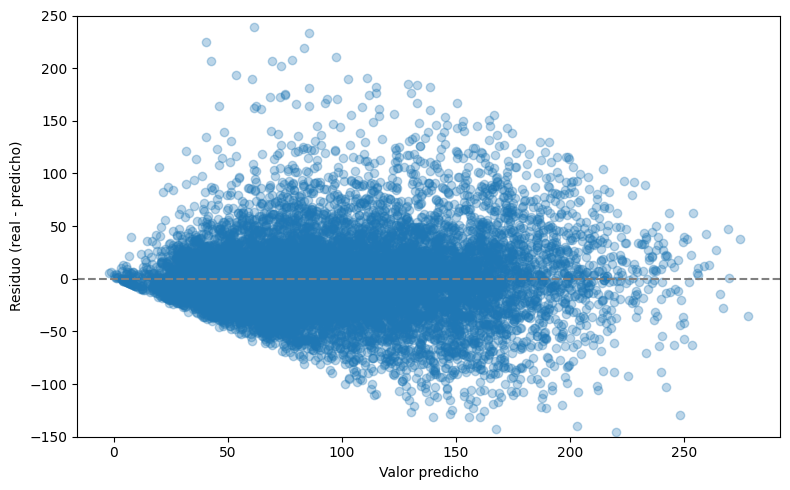

In [385]:
# Gráfico de residuos
 
residuals_cat = y_test - y_pred
 
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals_cat, alpha=0.3)
plt.axhline(0, linestyle='--', color='gray')
plt.ylim(-150, 250)
plt.xlabel("Valor predicho")
plt.ylabel("Residuo (real - predicho)")
plt.tight_layout()
plt.show()

### Feature importance


Importancia de características (CatBoost):
                             Feature Id  Importances
0                               Destino     9.324828
1                           Alojamiento     7.857298
2                            Tipo_Viaje     6.309882
3                               Estadia     6.236665
4                          Lugar Egreso     6.131864
5                          Personas_Dia     5.549080
6                       TransporteLocal     5.521555
7                   Quarter_Year_Egreso     5.501745
8                  Quarter_Year_Ingreso     5.247109
9                          Departamento     4.580684
10                                Gente     4.410511
11                            Ocupacion     4.208735
12                                 Pais     3.802416
13                            Localidad     3.555766
14                           Mes_Egreso     3.311526
15                               Motivo     2.944621
16                           Residencia     2.711516
17

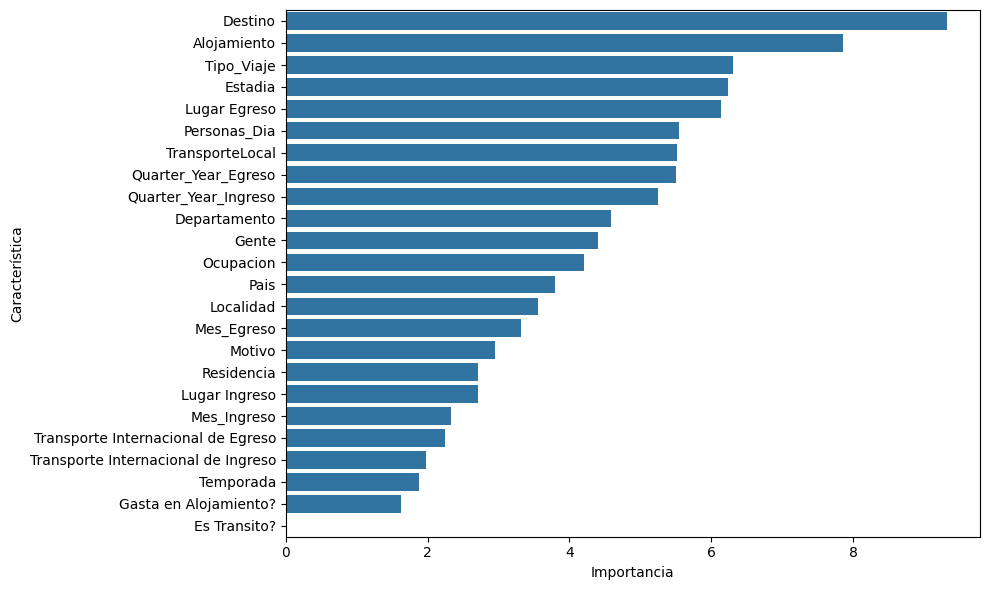

In [386]:
importances = best_model.get_feature_importance(prettified=True)

print("\nImportancia de características (CatBoost):")
print(importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=importances.sort_values('Importances', ascending=False))
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

In [387]:
# Predicciones por grupo

y_pred_cat = best_model.predict(X_test)

print("CatBoost: desempeño por DESTINO ")
print(performance_por_grupo(df_test, y_test, y_pred_cat, "Destino"))

print("\n")

print("CatBoost: desempeño por ALOJAMIENTO ")
print(performance_por_grupo(df_test, y_test, y_pred_cat, "Alojamiento"))

CatBoost: desempeño por DESTINO 
            Destino        MAE       RMSE     Hit10     Hit20     Hit30
1      Costa de Oro  13.908418  19.226127  0.269091  0.494545  0.661818
3    Litoral Termal  16.341294  23.382999  0.268504  0.476774  0.622256
2  Costas Oceanicas  18.852732  25.573447  0.259109  0.445344  0.607287
5             Otros  19.578227  27.662472  0.198942  0.356614  0.524868
8          Transito  19.800876  28.839446  0.151724  0.320690  0.417241
6        Piriapolis  21.915388  29.235165  0.290061  0.523327  0.701826
0           Colonia  29.070045  41.004944  0.199174  0.388430  0.555372
4        Montevideo  30.285163  41.201755  0.259347  0.454330  0.596072
7    Punta del Este  35.586702  46.427852  0.282855  0.516971  0.673629


CatBoost: desempeño por ALOJAMIENTO 
                  Alojamiento        MAE       RMSE     Hit10     Hit20  \
5             Vivienda propia  22.506005  31.338662  0.363757  0.645503   
4  Vivienda familiares/amigos  22.879188  31.616313  0.161

### Observación nueva

In [388]:
columnas_modelo = [
    'Lugar Ingreso',
    'Transporte Internacional de Ingreso',
    'Pais',
    'Residencia',
    'Motivo',
    'Ocupacion',
    'Localidad',
    'Departamento',
    'Alojamiento',
    'TransporteLocal',
    'Lugar Egreso',
    'Transporte Internacional de Egreso',
    'Destino',
    'Estadia',
    'Gente',
    'Mes_Ingreso',
    'Mes_Egreso',
    'Quarter_Year_Ingreso',
    'Quarter_Year_Egreso',
    'Temporada',
    'Gasta en Alojamiento?',
    'Es Transito?',
    'Personas_Dia',
    'Gasto/p/d',
    'Tipo_Viaje'
]

df_nuevo = pd.DataFrame(columns=columnas_modelo)

df_nuevo.loc[0] = {
    'Lugar Ingreso': 'Aeropuerto de Carrasco',
    'Transporte Internacional de Ingreso': 'Aereo',
    'Pais': 'Otro de America',
    'Residencia': 'Otras ciudades Sudamerica',
    'Motivo': 'Ocio y vacaciones',
    'Ocupacion': 'Profesionales y Patrones',
    'Localidad': 'Montevideo',
    'Departamento': 'Montevideo',
    'Alojamiento': 'Otros Hoteles',
    'TransporteLocal': 'Taxi - Bus',
    'Lugar Egreso': 'Aeropuerto de Carrasco',
    'Transporte Internacional de Egreso': 'Aereo',
    'Destino': 'Montevideo',
    'Estadia': 11,
    'Gente': 2,
    'Mes_Ingreso': 2,
    'Mes_Egreso': 2,
    'Quarter_Year_Ingreso': '20171',
    'Quarter_Year_Egreso': '20171',
    'Temporada': 'Alta',
    'Gasta en Alojamiento?': 'Si',
    'Es Transito?': 'No',
    'Gasto/p/d': np.nan,
}

df_nuevo['Personas_Dia'] = df_nuevo['Gente'] * df_nuevo['Estadia']
df_nuevo['Tipo_Viaje'] = df_nuevo['Motivo'] + "_" + df_nuevo['Alojamiento']
df_nuevo


Lugar Ingreso Transporte Internacional de Ingreso  \
0  Aeropuerto de Carrasco                               Aereo   

              Pais                 Residencia             Motivo  \
0  Otro de America  Otras ciudades Sudamerica  Ocio y vacaciones   

                  Ocupacion   Localidad Departamento    Alojamiento  \
0  Profesionales y Patrones  Montevideo   Montevideo  Otros Hoteles   

  TransporteLocal  ... Mes_Ingreso Mes_Egreso Quarter_Year_Ingreso  \
0      Taxi - Bus  ...           2          2                20171   

   Quarter_Year_Egreso  Temporada  Gasta en Alojamiento?  Es Transito?  \
0                20171       Alta                     Si            No   

  Personas_Dia Gasto/p/d                       Tipo_Viaje  
0           22       NaN  Ocio y vacaciones_Otros Hoteles  

[1 rows x 25 columns]

In [389]:
X_nuevo = df_nuevo.drop(columns=['Gasto/p/d'])

prediccion = best_model.predict(X_nuevo)

print(f"Predicción estimada de Gasto/p/d: {prediccion[0]:.2f}")

Predicción estimada de Gasto/p/d: 114.43


In [390]:
y_real = [113.18]
y_pred = [prediccion[0]]

mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2 = r2_score(y_real, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE:  1.25
RMSE: 1.25


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [391]:
df_test.head()

Lugar Ingreso Transporte Internacional de Ingreso  \
1006                       Paysandú                           Terrestre   
21401  Aeropuerto de Punta del Este                               Aereo   
10929                        Rivera                           Terrestre   
31910                       Colonia                            Maritimo   
14391                      Paysandú                           Terrestre   

            Pais Residencia                        Motivo  \
1006   Argentina  Argentina                      Transito   
21401     Brasil     Brasil  Visita a familiares y amigos   
10929  Argentina  Argentina                      Transito   
31910    Uruguay  Argentina  Visita a familiares y amigos   
14391  Argentina  Argentina             Ocio y vacaciones   

                      Ocupacion               Localidad Departamento  \
1006   Profesionales y Patrones                Transito     Transito   
21401  Profesionales y Patrones          Punta del Este    Maldonado   
10929    Inactivos con ingresos                Transito     Transito   
31910               Empleados B  Colonia del Sacramento      Colonia   
14391               Empleados B                Paysandu        Otros   

                      Alojamiento           TransporteLocal  ...   Gasto/p/d  \
1006                Otros Hoteles               Auto propio  ...   18.000000   
21401     Hoteles 4 y 5 estrellas                Taxi - Bus  ...  220.010000   
10929               Otros Hoteles               Auto propio  ...  123.395000   
31910  Vivienda familiares/amigos  Auto familiares / amigos  ...   46.881875   
14391  Vivienda familiares/amigos               Auto propio  ...   50.948333   

      Mes_Ingreso Mes_Egreso  Quarter_Year_Ingreso  Quarter_Year_Egreso  \
1006            1          1                 20181                20181   
21401          12         12                 20194                20194   
10929           5          5                 20182                20182   
31910           1          1                 20241                20241   
14391           5          5                 20232                20232   

       Temporada  Gasta en Alojamiento?  Es Transito?  Personas_Dia  \
1006        Alta                     Si            Sí             5   
21401       Alta                     Si            No             6   
10929      Media                     Si            No             4   
31910       Alta                     No            No            16   
14391      Media                     No            No             6   

                                              Tipo_Viaje  
1006                              Transito_Otros Hoteles  
21401  Visita a familiares y amigos_Hoteles 4 y 5 est...  
10929                             Transito_Otros Hoteles  
31910  Visita a familiares y amigos_Vivienda familiar...  
14391       Ocio y vacaciones_Vivienda familiares/amigos  

[5 rows x 25 columns]

## Random Forest

### One Hot Encoding

In [272]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_cols]))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_cols]))

X_train_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X_test_encoded.columns = encoder.get_feature_names_out(categorical_cols)

X_train_final = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True),
                           X_train_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True),
                          X_test_encoded.reset_index(drop=True)], axis=1)

In [273]:
X_train_final.shape

(51016, 148)

### Búsqueda de mejores hiperparámetros

#### Train

In [274]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [800, 1200, 1500],
    'max_depth': [6, 8, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 0.2, 0.3, 0.5],
    'bootstrap': [True]
}

scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error'
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=500,
    cv=5,
    scoring=scoring,
    refit='r2',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train_final, y_train)

print("Mejores hiperparámetros:", rf_search.best_params_)
print("Mejor R² CV:", rf_search.best_score_)

cv_results = rf_search.cv_results_
best_idx = rf_search.best_index_

print("\n Métricas de CV del mejor Random Forest:")

print(f"R² CV   : {cv_results['mean_test_r2'][best_idx]:.4f}")
print(f"MAE CV  : {-cv_results['mean_test_mae'][best_idx]:.4f}")
print(f"RMSE CV : {-cv_results['mean_test_rmse'][best_idx]:.4f}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejores hiperparámetros: {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None, 'bootstrap': True}
Mejor R² CV: 0.6164789794156476

 Métricas de CV del mejor Random Forest:
R² CV   : 0.6165
MAE CV  : 27.1954
RMSE CV : 38.0709


#### Test

In [275]:
best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test_final)

umbrales = [0.10, 0.20, 0.30]

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n Evaluación en test:")
print(f"R²:   {r2:.3f}")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

for umbral in umbrales:
    hr = hit_rate(y_test, y_pred, umbral)
    print(f"Hit Rate {int(umbral*100)}%: {hr:.4f}")


 Evaluación en test:
R²:   0.628
MAE:  26.72
RMSE: 37.63
Hit Rate 10%: 0.2549
Hit Rate 20%: 0.4501
Hit Rate 30%: 0.5958


### Mejores parámetros

#### Train

In [276]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [1200],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'max_features': [0.3],
    'bootstrap': [True]
}

scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error'
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=500,
    cv=5,
    scoring=scoring,
    refit='r2',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train_final, y_train)

print("Mejores hiperparámetros:", rf_search.best_params_)
print("Mejor R² CV:", rf_search.best_score_)

cv_results = rf_search.cv_results_
best_idx = rf_search.best_index_

print("\n Métricas de CV del mejor Random Forest:")

print(f"R² CV   : {cv_results['mean_test_r2'][best_idx]:.4f}")
print(f"MAE CV  : {-cv_results['mean_test_mae'][best_idx]:.4f}")
print(f"RMSE CV : {-cv_results['mean_test_rmse'][best_idx]:.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=500. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros: {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None, 'bootstrap': True}
Mejor R² CV: 0.6164789794156476

 Métricas de CV del mejor Random Forest:
R² CV   : 0.6165
MAE CV  : 27.1954
RMSE CV : 38.0709


#### Test

In [277]:
best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test_final)

umbrales = [0.10, 0.20, 0.30]

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n Evaluación en test:")
print(f"R²:   {r2:.3f}")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

for umbral in umbrales:
    hr = hit_rate(y_test, y_pred, umbral)
    print(f"Hit Rate {int(umbral*100)}%: {hr:.4f}")


 Evaluación en test:
R²:   0.628
MAE:  26.72
RMSE: 37.63
Hit Rate 10%: 0.2549
Hit Rate 20%: 0.4501
Hit Rate 30%: 0.5958


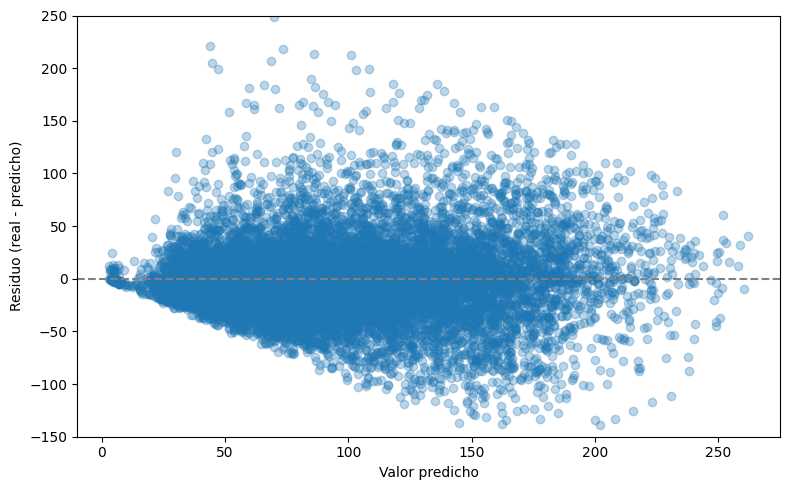

In [284]:
# Gráfico de residuos
 
residuals_rf = y_test - y_pred
 
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals_rf, alpha=0.3)
plt.axhline(0, linestyle='--', color='gray')
plt.ylim(-150, 250)
plt.xlabel("Valor predicho")
plt.ylabel("Residuo (real - predicho)")
plt.tight_layout()
plt.show()

### Feature importance

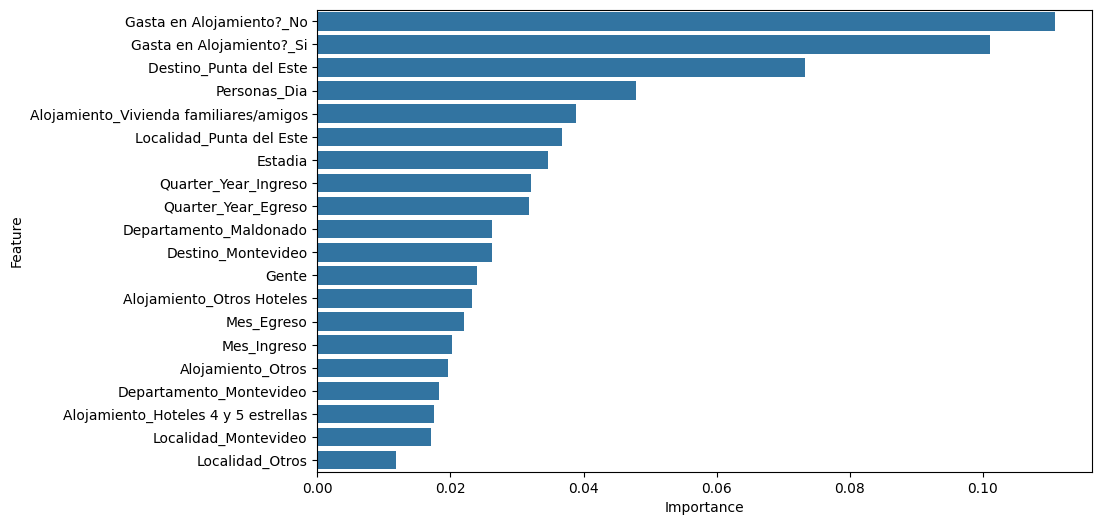

In [281]:
importances = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(20))
plt.show()

In [280]:
# Predicciones por grupo

y_pred_rf = best_rf.predict(X_test_final)

print("Random Forest: desempeño por DESTINO ")
print(performance_por_grupo(df_test, y_test, y_pred_rf, "Destino"))

print("\n")

print("Random Forest: desempeño por ALOJAMIENTO ")
print(performance_por_grupo(df_test, y_test, y_pred_rf, "Alojamiento"))

Random Forest: desempeño por DESTINO 
            Destino        MAE       RMSE     Hit10     Hit20     Hit30
1      Costa de Oro  14.206723  19.147766  0.269091  0.483636  0.649091
3    Litoral Termal  16.426093  23.524272  0.265952  0.473201  0.618173
8          Transito  19.381759  28.684461  0.174138  0.294828  0.412069
5             Otros  19.710046  27.528873  0.198942  0.364021  0.511111
2  Costas Oceanicas  19.916577  26.380672  0.234818  0.410931  0.585020
6        Piriapolis  22.274248  29.997787  0.296146  0.533469  0.705882
0           Colonia  29.440971  41.318885  0.212397  0.385124  0.541322
4        Montevideo  30.706029  41.768004  0.264316  0.460719  0.597255
7    Punta del Este  36.887300  48.283176  0.285901  0.502176  0.649695


Random Forest: desempeño por ALOJAMIENTO 
                  Alojamiento        MAE       RMSE     Hit10     Hit20  \
4  Vivienda familiares/amigos  23.115575  31.940077  0.164875  0.328076   
5             Vivienda propia  23.669163  32.746